In [1]:
from pyNBS import data_import_tools as dit
from pyNBS import network_propagation as prop
from pyNBS import pyNBS_core as core
from pyNBS import pyNBS_single
from pyNBS import consensus_clustering as cc
from pyNBS import pyNBS_plotting as plot
from sklearn.metrics.cluster import adjusted_mutual_info_score, adjusted_rand_score
import time
import networkx as nx
import pandas as pd
import numpy as np
from IPython.display import Image

## Base case 

In [93]:
run_pyNBS_params = {'verbose' : True,
                    
                    ##### Path for HNSC #####
                    # Data used in this notebook is located in /data folder in the repository.
                    # To run this notebook, please modify the path to indicate your local directory.
                    # If you would like to use your own data file, 
                    # please refer to the "Load data" cell below for formatting details.
                     
                    # Please make sure you modify file path for loading/saving to indicate your local directory                 
                    'sm_data_file' : '/cellar/users/t1jia/pyNBS/data/Mutation_Files/HNSC_sm_data.txt',
                    'network_path' : '/cellar/users/t1jia/pyNBS/data/Network_Files/CancerSubnetwork.txt',
                    
                    'mut_filetype' : 'list',
                    'mut_filedelim' : '\t',
                    'net_filedelim' : '\t',
                    'degree_preserved_shuffle' : False,
                    'node_label_shuffle' : False,
                    
                    'regularize_network' : True,
                    'reg_net_gamma' : 0.01,
                    'k_nearest_neighbors' : 11,
                    'save_knn_glap' : None,
                    'regularization_network_graph_laplacian_file' : None,
                    'niter' : 100, 
                    'calculate_propagation_kernel' : True,
                    
                    'propagation_kernel_file' : None,
                    'save_kernel' : None,
                    'save_H' : None,
                    'consensus_cluster' : True,
                    'assign_clusters' : True,
                    'save_co_cluster_matrix' : '/cellar/users/t1jia/pyNBS/Supplementary_Notebooks/results/base_case/HNSC_co_cluster_matrix.csv',
                    'save_cluster_assignments' : '/cellar/users/t1jia/pyNBS/Supplementary_Notebooks/results/base_case/HNSC_cluster_assignment.csv',
                    'plot_co_cluster_map' : True,
                    'plot_title' : 'HNSC Consensus Cluster Map',
                    'save_co_cluster_map' : '/cellar/users/t1jia/pyNBS/Supplementary_Notebooks/results/base_case/HNSC_co_cluster.png',
                    'save_km_plot' : '/cellar/users/t1jia/pyNBS/Supplementary_Notebooks/results/base_case/HNSC_KM_plot.png'
                    }

In [94]:
NBS_options = {'pats_subsample_p' : 0.8, 
               'gene_subsample_p' : 0.8, 
               'min_muts' : 10,
               'prop_data' : True, 
               'prop_alpha' : 0.7, 
               'prop_symmetric_norm' : False, 
               'qnorm_data' : True,
               'netNMF_k' : 4, 
               'netNMF_gamma' : 200, 
               'netNMF_update_gamma' : False, 
               'netNMF_gamma_factor' : 1,
               'netNMF_niter' : 250, 
               'netNMF_eps' : 1e-15, 
               'netNMF_err_tol' : 1e-4, 
               'netNMF_err_delta_tol' : 1e-8}

In [95]:
# Load somatic mutation data
sm_mat = dit.load_binary_mutation_data(run_pyNBS_params['sm_data_file'], filetype=run_pyNBS_params['mut_filetype'], delimiter=run_pyNBS_params['mut_filedelim'], verbose=run_pyNBS_params['verbose'])
# Load network
network = dit.load_network_file(run_pyNBS_params['network_path'], delimiter=run_pyNBS_params['net_filedelim'], degree_shuffle=run_pyNBS_params['degree_preserved_shuffle'], 
                                label_shuffle=run_pyNBS_params['node_label_shuffle'], verbose=run_pyNBS_params['verbose'])


Binary Mutation Matrix Loaded: /cellar/users/t1jia/pyNBS/data/Mutation_Files/HNSC_sm_data.txt
Network File Loaded: /cellar/users/t1jia/pyNBS/data/Network_Files/CancerSubnetwork.txt


In [96]:
# Get knnGlap
if run_pyNBS_params['regularize_network']:
    knnGlap = core.network_inf_KNN_glap(network, gamma=run_pyNBS_params['reg_net_gamma'], kn=run_pyNBS_params['k_nearest_neighbors'], verbose=run_pyNBS_params['verbose'], save_path=run_pyNBS_params['save_knn_glap'])
else:
    # Load propatagion kernel
    if run_pyNBS_params['regularization_network_graph_laplacian_file'].endswith('.hdf'):
        knnGlap = pd.read_hdf(run_pyNBS_params['regularization_network_graph_laplacian_file'])
    else:
        knnGlap = pd.read_csv(run_pyNBS_params['regularization_network_graph_laplacian_file'])
    if run_pyNBS_params['verbose']:
        print 'Pre-calculated regularization network graph laplacian loaded'

Graph influence matrix calculated: 2.4102768898 seconds
Graph laplacian of KNN network from influence matrix calculated: 4.72848391533 seconds


In [97]:
# Get network propagation kernel
if run_pyNBS_params['propagation_kernel_file'] is not None:
    # Load propagation kernel
    if run_pyNBS_params['propagation_kernel_file'].endswith('.hdf'):
        kernel = pd.read_hdf(run_pyNBS_params['propagation_kernel_file'])
    else:
        kernel = pd.read_csv(run_pyNBS_params['propagation_kernel_file'])
    if run_pyNBS_params['verbose']:
        print 'Pre-calculated network kernel loaded'
else:
    if run_pyNBS_params['calculate_propagation_kernel']:
        # Calculate propagation kernel by propagating identity matrix of network
        network_nodes = network.nodes()
        network_I = pd.DataFrame(np.identity(len(network_nodes)), index=network_nodes, columns=network_nodes)
        kernel = prop.network_propagation(network, network_I, NBS_options['prop_alpha'], symmetric_norm=NBS_options['prop_symmetric_norm'], verbose=run_pyNBS_params['verbose'], save_path=run_pyNBS_params['save_kernel'])  
        if run_pyNBS_params['verbose']:
            print 'Network kernel calculated'
    else:
        kernel = None
        if run_pyNBS_params['verbose']:
            print 'No network kernel established'

Performing network propagation with alpha: 0.7
Network Propagation Complete: 3.45491313934 seconds
Network kernel calculated


In [98]:
Hlist = []
for i in range(run_pyNBS_params['niter']):
    netNMF_time = time.time()
    Hlist.append(pyNBS_single.NBS_single(sm_mat, NBS_options, propNet=network, propNet_kernel=kernel, regNet_glap=knnGlap, verbose=False, save_path=run_pyNBS_params['save_H']))
    if run_pyNBS_params['verbose']:
        t = time.time()-netNMF_time
        print 'NBS iteration:', i+1, 'complete:', t, 'seconds'

NBS iteration: 1 complete: 25.0776021481 seconds
NBS iteration: 2 complete: 25.8563210964 seconds
NBS iteration: 3 complete: 22.7181138992 seconds
NBS iteration: 4 complete: 23.7446360588 seconds
NBS iteration: 5 complete: 23.2621331215 seconds
NBS iteration: 6 complete: 23.1350529194 seconds
NBS iteration: 7 complete: 23.2130680084 seconds
NBS iteration: 8 complete: 23.5009789467 seconds
NBS iteration: 9 complete: 23.6514379978 seconds
NBS iteration: 10 complete: 23.1212990284 seconds
NBS iteration: 11 complete: 25.7724311352 seconds
NBS iteration: 12 complete: 26.2333679199 seconds
NBS iteration: 13 complete: 25.1669728756 seconds
NBS iteration: 14 complete: 23.0390648842 seconds
NBS iteration: 15 complete: 23.7776069641 seconds
NBS iteration: 16 complete: 23.5529108047 seconds
NBS iteration: 17 complete: 23.9733970165 seconds
NBS iteration: 18 complete: 24.1791460514 seconds
NBS iteration: 19 complete: 24.0143070221 seconds
NBS iteration: 20 complete: 23.5199580193 seconds
NBS itera

In [99]:
if run_pyNBS_params['consensus_cluster']:
    NBS_cc_table, NBS_cc_linkage, NBS_cluster_assign = cc.consensus_hclust_hard(Hlist, NBS_options['netNMF_k'], assign_cluster=run_pyNBS_params['assign_clusters'])
    if run_pyNBS_params['verbose']:
        print 'Consensus Clustering complete'        
    if run_pyNBS_params['save_co_cluster_matrix'] is not None:
        NBS_cc_table.to_csv(run_pyNBS_params['save_co_cluster_matrix'])
        if run_pyNBS_params['verbose']:
            print 'Co-clustering matrix saved'
    if run_pyNBS_params['save_cluster_assignments'] is not None:
        NBS_cluster_assign.to_csv(run_pyNBS_params['save_cluster_assignments'])
        if run_pyNBS_params['verbose']:
            print 'Cluster assignments saved'

Consensus Clustering complete
Co-clustering matrix saved
Cluster assignments saved


In [100]:
# Plot Consensus Cluster Map
if run_pyNBS_params['plot_co_cluster_map']:
    NBS_cluster_assign_cmap = plot.cluster_color_assign(NBS_cluster_assign, name='pyNBS Cluster Assignment')
    plot.plot_cc_map(NBS_cc_table, NBS_cc_linkage, title=run_pyNBS_params['plot_title'], row_color_map=None, 
                     col_color_map=NBS_cluster_assign_cmap, save_path=run_pyNBS_params['save_co_cluster_map'])
    if run_pyNBS_params['verbose']:
        print 'Consensus Clustering map saved'

Consensus Clustering map saved


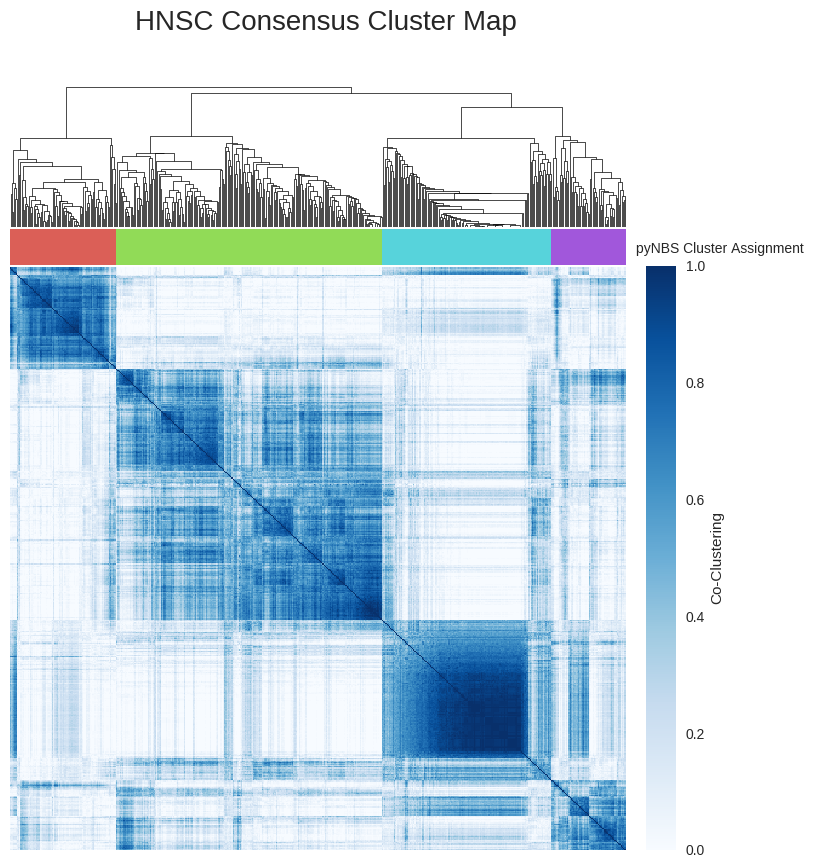

In [101]:
Image(filename = run_pyNBS_params['save_co_cluster_map'], width=600, height=600)

Multi-Class Log-Rank P: 0.0378036009889


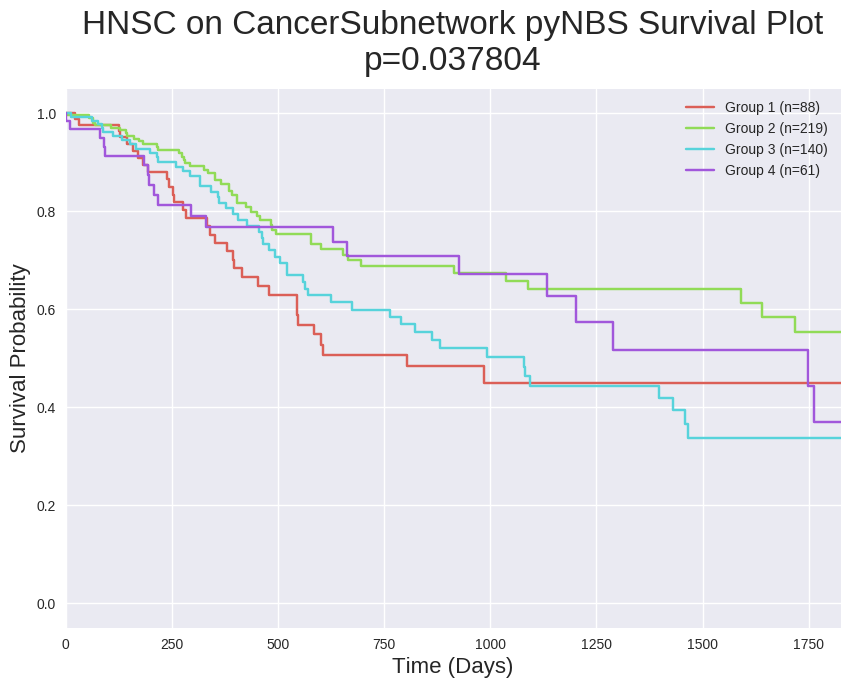

In [102]:
clin_path = '/cellar/users/t1jia/pyNBS/data/Clinical_Files/HNSC.clin.merged.surv.txt'
plot.cluster_KMplot(NBS_cluster_assign,clin_path,title='HNSC on CancerSubnetwork pyNBS Survival Plot', save_path = run_pyNBS_params['save_km_plot'])
Image(filename = run_pyNBS_params['save_km_plot'], width=600, height=600)

## With NH90 network

In [12]:
run_pyNBS_params = {'verbose' : True,
                    
                    ##### Path for HNSC #####
                    # Data used in this notebook is located in /data folder in the repository.
                    # To run this notebook, please modify the path to indicate your local directory.
                    # If you would like to use your own data file, 
                    # please refer to the "Load data" cell below for formatting details.
                     
                    # Please make sure you modify file path for loading/saving to indicate your local directory                 
                    'sm_data_file' : '/cellar/users/t1jia/pyNBS/data/Mutation_Files/HNSC_sm_data.txt',
                    'network_path' : '/cellar/users/t1jia/pyNBS/data/Network_Files/HumanNet90_Symbol.sif',
                    
                    'mut_filetype' : 'list',
                    'mut_filedelim' : '\t',
                    'net_filedelim' : '\t',
                    'degree_preserved_shuffle' : False,
                    'node_label_shuffle' : False,
                    
                    'regularize_network' : True,
                    'reg_net_gamma' : 0.01,
                    'k_nearest_neighbors' : 11,
                    'save_knn_glap' : None,
                    'regularization_network_graph_laplacian_file' : None,
                    'niter' : 100, 
                    'calculate_propagation_kernel' : True,
                    
                    'propagation_kernel_file' : None,
                    'save_kernel' : None,
                    'save_H' : None,
                    'consensus_cluster' : True,
                    'assign_clusters' : True,
                    'save_co_cluster_matrix' : '/cellar/users/t1jia/pyNBS/Supplementary_Notebooks/results/HN90/HNSC_co_cluster_matrix.csv',
                    'save_cluster_assignments' : '/cellar/users/t1jia/pyNBS/Supplementary_Notebooks/results/HN90/HNSC_cluster_assignment.csv',
                    'plot_co_cluster_map' : True,
                    'plot_title' : 'HNSC Consensus Cluster Map',
                    'save_co_cluster_map' : '/cellar/users/t1jia/pyNBS/Supplementary_Notebooks/results/HN90/HNSC_co_cluster.png',
                    'save_km_plot' : '/cellar/users/t1jia/pyNBS/Supplementary_Notebooks/results/HN90/HNSC_KM_plot.png'
                    }

In [13]:
NBS_options = {'pats_subsample_p' : 0.8, 
               'gene_subsample_p' : 0.8, 
               'min_muts' : 10,
               'prop_data' : True, 
               'prop_alpha' : 0.7, 
               'prop_symmetric_norm' : False, 
               'qnorm_data' : True,
               'netNMF_k' : 4, 
               'netNMF_gamma' : 200, 
               'netNMF_update_gamma' : False, 
               'netNMF_gamma_factor' : 1,
               'netNMF_niter' : 250, 
               'netNMF_eps' : 1e-15, 
               'netNMF_err_tol' : 1e-4, 
               'netNMF_err_delta_tol' : 1e-8}

In [14]:
# Load somatic mutation data
sm_mat = dit.load_binary_mutation_data(run_pyNBS_params['sm_data_file'], filetype=run_pyNBS_params['mut_filetype'], delimiter=run_pyNBS_params['mut_filedelim'], verbose=run_pyNBS_params['verbose'])
# Load network
network = dit.load_network_file(run_pyNBS_params['network_path'], delimiter=run_pyNBS_params['net_filedelim'], degree_shuffle=run_pyNBS_params['degree_preserved_shuffle'], 
                                label_shuffle=run_pyNBS_params['node_label_shuffle'], verbose=run_pyNBS_params['verbose'])


Binary Mutation Matrix Loaded: /cellar/users/t1jia/pyNBS/data/Mutation_Files/HNSC_sm_data.txt
Network File Loaded: /cellar/users/t1jia/pyNBS/data/Network_Files/HumanNet90_Symbol.sif


In [15]:
# Get knnGlap
if run_pyNBS_params['regularize_network']:
    knnGlap = core.network_inf_KNN_glap(network, gamma=run_pyNBS_params['reg_net_gamma'], kn=run_pyNBS_params['k_nearest_neighbors'], verbose=run_pyNBS_params['verbose'], save_path=run_pyNBS_params['save_knn_glap'])
else:
    # Load propatagion kernel
    if run_pyNBS_params['regularization_network_graph_laplacian_file'].endswith('.hdf'):
        knnGlap = pd.read_hdf(run_pyNBS_params['regularization_network_graph_laplacian_file'])
    else:
        knnGlap = pd.read_csv(run_pyNBS_params['regularization_network_graph_laplacian_file'])
    if run_pyNBS_params['verbose']:
        print 'Pre-calculated regularization network graph laplacian loaded'

Graph influence matrix calculated: 20.7148749828 seconds
Graph laplacian of KNN network from influence matrix calculated: 22.3331460953 seconds


In [16]:
# Get network propagation kernel
if run_pyNBS_params['propagation_kernel_file'] is not None:
    # Load propagation kernel
    if run_pyNBS_params['propagation_kernel_file'].endswith('.hdf'):
        kernel = pd.read_hdf(run_pyNBS_params['propagation_kernel_file'])
    else:
        kernel = pd.read_csv(run_pyNBS_params['propagation_kernel_file'])
    if run_pyNBS_params['verbose']:
        print 'Pre-calculated network kernel loaded'
else:
    if run_pyNBS_params['calculate_propagation_kernel']:
        # Calculate propagation kernel by propagating identity matrix of network
        network_nodes = network.nodes()
        network_I = pd.DataFrame(np.identity(len(network_nodes)), index=network_nodes, columns=network_nodes)
        kernel = prop.network_propagation(network, network_I, NBS_options['prop_alpha'], symmetric_norm=NBS_options['prop_symmetric_norm'], verbose=run_pyNBS_params['verbose'], save_path=run_pyNBS_params['save_kernel'])  
        if run_pyNBS_params['verbose']:
            print 'Network kernel calculated'
    else:
        kernel = None
        if run_pyNBS_params['verbose']:
            print 'No network kernel established'

Performing network propagation with alpha: 0.7
Network Propagation Complete: 69.2723758221 seconds
Network kernel calculated


In [17]:
Hlist = []
for i in range(run_pyNBS_params['niter']):
    netNMF_time = time.time()
    Hlist.append(pyNBS_single.NBS_single(sm_mat, NBS_options, propNet=network, propNet_kernel=kernel, regNet_glap=knnGlap, verbose=False, save_path=run_pyNBS_params['save_H']))
    if run_pyNBS_params['verbose']:
        t = time.time()-netNMF_time
        print 'NBS iteration:', i+1, 'complete:', t, 'seconds'

NBS iteration: 1 complete: 98.8938660622 seconds
NBS iteration: 2 complete: 98.5443549156 seconds
NBS iteration: 3 complete: 99.2800631523 seconds
NBS iteration: 4 complete: 98.5924339294 seconds
NBS iteration: 5 complete: 98.9713869095 seconds
NBS iteration: 6 complete: 99.5362808704 seconds
NBS iteration: 7 complete: 98.3689498901 seconds
NBS iteration: 8 complete: 99.4915041924 seconds
NBS iteration: 9 complete: 98.8831949234 seconds
NBS iteration: 10 complete: 99.0077121258 seconds
NBS iteration: 11 complete: 98.5845839977 seconds
NBS iteration: 12 complete: 98.9469339848 seconds
NBS iteration: 13 complete: 98.7448060513 seconds
NBS iteration: 14 complete: 98.0364739895 seconds
NBS iteration: 15 complete: 99.5023372173 seconds
NBS iteration: 16 complete: 98.4367828369 seconds
NBS iteration: 17 complete: 98.8390610218 seconds
NBS iteration: 18 complete: 99.8875210285 seconds
NBS iteration: 19 complete: 99.2985589504 seconds
NBS iteration: 20 complete: 99.2161779404 seconds
NBS itera

In [18]:
if run_pyNBS_params['consensus_cluster']:
    NBS_cc_table, NBS_cc_linkage, NBS_cluster_assign = cc.consensus_hclust_hard(Hlist, NBS_options['netNMF_k'], assign_cluster=run_pyNBS_params['assign_clusters'])
    if run_pyNBS_params['verbose']:
        print 'Consensus Clustering complete'        
    if run_pyNBS_params['save_co_cluster_matrix'] is not None:
        NBS_cc_table.to_csv(run_pyNBS_params['save_co_cluster_matrix'])
        if run_pyNBS_params['verbose']:
            print 'Co-clustering matrix saved'
    if run_pyNBS_params['save_cluster_assignments'] is not None:
        NBS_cluster_assign.to_csv(run_pyNBS_params['save_cluster_assignments'])
        if run_pyNBS_params['verbose']:
            print 'Cluster assignments saved'

Consensus Clustering complete
Co-clustering matrix saved
Cluster assignments saved


In [19]:
# Plot Consensus Cluster Map
if run_pyNBS_params['plot_co_cluster_map']:
    NBS_cluster_assign_cmap = plot.cluster_color_assign(NBS_cluster_assign, name='pyNBS Cluster Assignment')
    plot.plot_cc_map(NBS_cc_table, NBS_cc_linkage, title=run_pyNBS_params['plot_title'], row_color_map=None, 
                     col_color_map=NBS_cluster_assign_cmap, save_path=run_pyNBS_params['save_co_cluster_map'])
    if run_pyNBS_params['verbose']:
        print 'Consensus Clustering map saved'

Consensus Clustering map saved


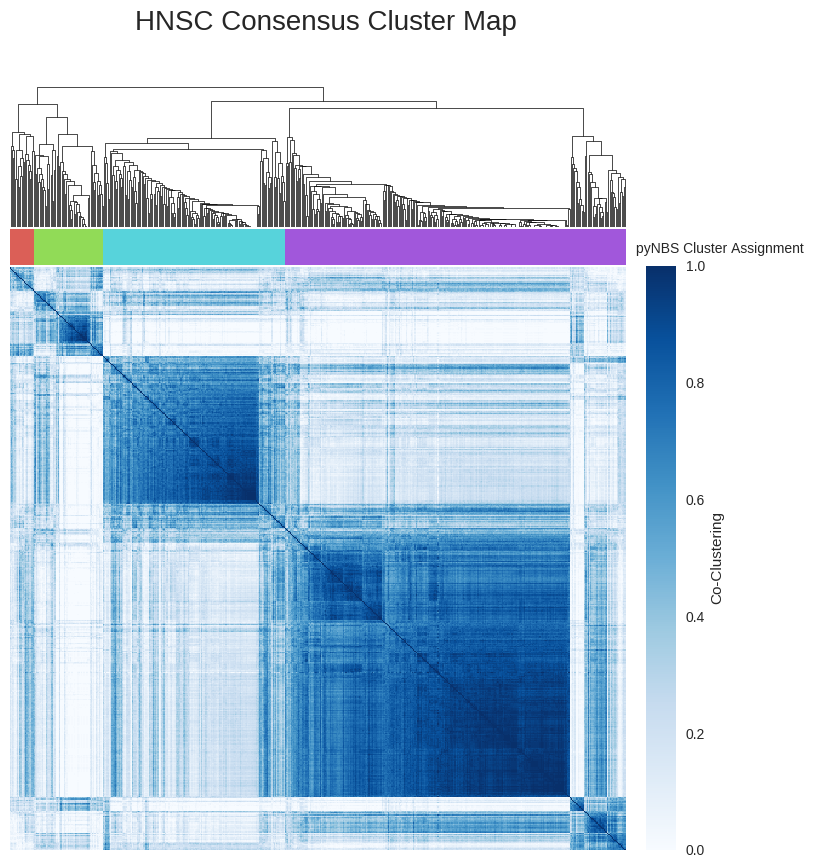

In [20]:
Image(filename = run_pyNBS_params['save_co_cluster_map'], width=600, height=600)

Multi-Class Log-Rank P: 0.871759912876


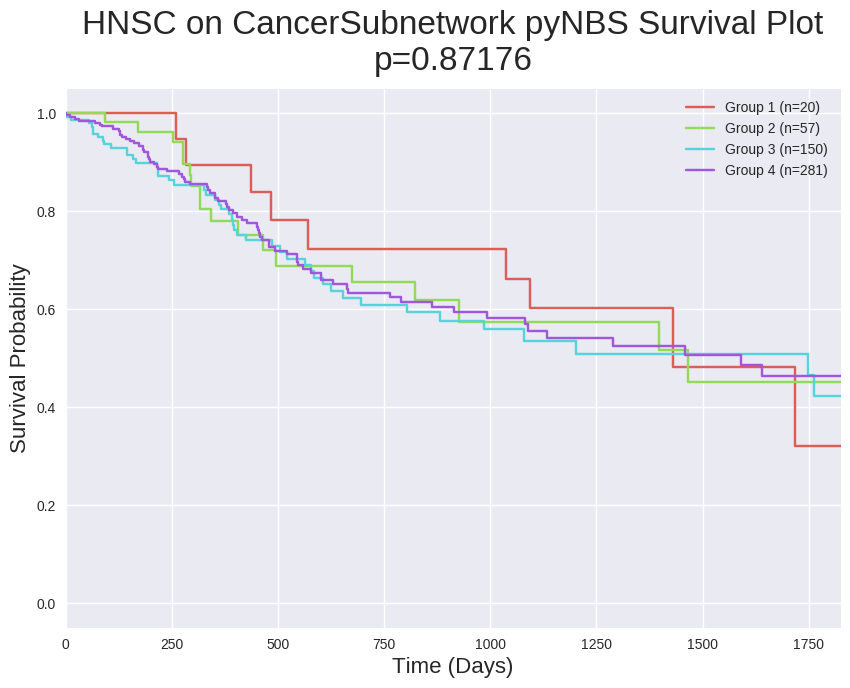

In [21]:
clin_path = '/cellar/users/t1jia/pyNBS/data/Clinical_Files/HNSC.clin.merged.surv.txt'
plot.cluster_KMplot(NBS_cluster_assign,clin_path,title='HNSC on CancerSubnetwork pyNBS Survival Plot', save_path = run_pyNBS_params['save_km_plot'])
Image(filename = run_pyNBS_params['save_km_plot'], width=600, height=600)

## With PID 

In [22]:
run_pyNBS_params = {'verbose' : True,
                    
                    ##### Path for HNSC #####
                    # Data used in this notebook is located in /data folder in the repository.
                    # To run this notebook, please modify the path to indicate your local directory.
                    # If you would like to use your own data file, 
                    # please refer to the "Load data" cell below for formatting details.
                     
                    # Please make sure you modify file path for loading/saving to indicate your local directory                 
                    'sm_data_file' : '/cellar/users/t1jia/pyNBS/data/Mutation_Files/HNSC_sm_data.txt',
                    'network_path' : '/cellar/users/t1jia/pyNBS/data/Network_Files/PID.txt',
                    
                    'mut_filetype' : 'list',
                    'mut_filedelim' : '\t',
                    'net_filedelim' : '\t',
                    'degree_preserved_shuffle' : False,
                    'node_label_shuffle' : False,
                    
                    'regularize_network' : True,
                    'reg_net_gamma' : 0.01,
                    'k_nearest_neighbors' : 11,
                    'save_knn_glap' : None,
                    'regularization_network_graph_laplacian_file' : None,
                    'niter' : 100, 
                    'calculate_propagation_kernel' : True,
                    
                    'propagation_kernel_file' : None,
                    'save_kernel' : None,
                    'save_H' : None,
                    'consensus_cluster' : True,
                    'assign_clusters' : True,
                    'save_co_cluster_matrix' : '/cellar/users/t1jia/pyNBS/Supplementary_Notebooks/results/PID/HNSC_co_cluster_matrix.csv',
                    'save_cluster_assignments' : '/cellar/users/t1jia/pyNBS/Supplementary_Notebooks/results/PID/HNSC_cluster_assignment.csv',
                    'plot_co_cluster_map' : True,
                    'plot_title' : 'HNSC Consensus Cluster Map',
                    'save_co_cluster_map' : '/cellar/users/t1jia/pyNBS/Supplementary_Notebooks/results/PID/HNSC_co_cluster.png',
                    'save_km_plot' : '/cellar/users/t1jia/pyNBS/Supplementary_Notebooks/results/PID/HNSC_KM_plot.png'
                    }

In [23]:
NBS_options = {'pats_subsample_p' : 0.8, 
               'gene_subsample_p' : 0.8, 
               'min_muts' : 10,
               'prop_data' : True, 
               'prop_alpha' : 0.7, 
               'prop_symmetric_norm' : False, 
               'qnorm_data' : True,
               'netNMF_k' : 4, 
               'netNMF_gamma' : 200, 
               'netNMF_update_gamma' : False, 
               'netNMF_gamma_factor' : 1,
               'netNMF_niter' : 250, 
               'netNMF_eps' : 1e-15, 
               'netNMF_err_tol' : 1e-4, 
               'netNMF_err_delta_tol' : 1e-8}

In [25]:
# Load somatic mutation data
sm_mat = dit.load_binary_mutation_data(run_pyNBS_params['sm_data_file'], filetype=run_pyNBS_params['mut_filetype'], delimiter=run_pyNBS_params['mut_filedelim'], verbose=run_pyNBS_params['verbose'])
# Load network
network = dit.load_network_file(run_pyNBS_params['network_path'], delimiter=run_pyNBS_params['net_filedelim'], degree_shuffle=run_pyNBS_params['degree_preserved_shuffle'], 
                                label_shuffle=run_pyNBS_params['node_label_shuffle'], verbose=run_pyNBS_params['verbose'])


Binary Mutation Matrix Loaded: /cellar/users/t1jia/pyNBS/data/Mutation_Files/HNSC_sm_data.txt
Network File Loaded: /cellar/users/t1jia/pyNBS/data/Network_Files/PID.txt


In [26]:
# Get knnGlap
if run_pyNBS_params['regularize_network']:
    knnGlap = core.network_inf_KNN_glap(network, gamma=run_pyNBS_params['reg_net_gamma'], kn=run_pyNBS_params['k_nearest_neighbors'], verbose=run_pyNBS_params['verbose'], save_path=run_pyNBS_params['save_knn_glap'])
else:
    # Load propatagion kernel
    if run_pyNBS_params['regularization_network_graph_laplacian_file'].endswith('.hdf'):
        knnGlap = pd.read_hdf(run_pyNBS_params['regularization_network_graph_laplacian_file'])
    else:
        knnGlap = pd.read_csv(run_pyNBS_params['regularization_network_graph_laplacian_file'])
    if run_pyNBS_params['verbose']:
        print 'Pre-calculated regularization network graph laplacian loaded'

Graph influence matrix calculated: 2.32419300079 seconds
Graph laplacian of KNN network from influence matrix calculated: 7.58986020088 seconds


In [27]:
# Get network propagation kernel
if run_pyNBS_params['propagation_kernel_file'] is not None:
    # Load propagation kernel
    if run_pyNBS_params['propagation_kernel_file'].endswith('.hdf'):
        kernel = pd.read_hdf(run_pyNBS_params['propagation_kernel_file'])
    else:
        kernel = pd.read_csv(run_pyNBS_params['propagation_kernel_file'])
    if run_pyNBS_params['verbose']:
        print 'Pre-calculated network kernel loaded'
else:
    if run_pyNBS_params['calculate_propagation_kernel']:
        # Calculate propagation kernel by propagating identity matrix of network
        network_nodes = network.nodes()
        network_I = pd.DataFrame(np.identity(len(network_nodes)), index=network_nodes, columns=network_nodes)
        kernel = prop.network_propagation(network, network_I, NBS_options['prop_alpha'], symmetric_norm=NBS_options['prop_symmetric_norm'], verbose=run_pyNBS_params['verbose'], save_path=run_pyNBS_params['save_kernel'])  
        if run_pyNBS_params['verbose']:
            print 'Network kernel calculated'
    else:
        kernel = None
        if run_pyNBS_params['verbose']:
            print 'No network kernel established'

Performing network propagation with alpha: 0.7
Network Propagation Complete: 3.20831394196 seconds
Network kernel calculated


In [28]:
Hlist = []
for i in range(run_pyNBS_params['niter']):
    netNMF_time = time.time()
    Hlist.append(pyNBS_single.NBS_single(sm_mat, NBS_options, propNet=network, propNet_kernel=kernel, regNet_glap=knnGlap, verbose=False, save_path=run_pyNBS_params['save_H']))
    if run_pyNBS_params['verbose']:
        t = time.time()-netNMF_time
        print 'NBS iteration:', i+1, 'complete:', t, 'seconds'

NBS iteration: 1 complete: 30.9617669582 seconds
NBS iteration: 2 complete: 29.0163621902 seconds
NBS iteration: 3 complete: 30.3947899342 seconds
NBS iteration: 4 complete: 28.4070920944 seconds
NBS iteration: 5 complete: 36.821418047 seconds
NBS iteration: 6 complete: 29.4851360321 seconds
NBS iteration: 7 complete: 28.5822520256 seconds
NBS iteration: 8 complete: 25.9957652092 seconds
NBS iteration: 9 complete: 25.6839351654 seconds
NBS iteration: 10 complete: 25.6987740993 seconds
NBS iteration: 11 complete: 25.5912997723 seconds
NBS iteration: 12 complete: 25.7374010086 seconds
NBS iteration: 13 complete: 25.5145449638 seconds
NBS iteration: 14 complete: 26.287364006 seconds
NBS iteration: 15 complete: 30.4332149029 seconds
NBS iteration: 16 complete: 32.8556120396 seconds
NBS iteration: 17 complete: 33.1758890152 seconds
NBS iteration: 18 complete: 38.4738490582 seconds
NBS iteration: 19 complete: 30.9723210335 seconds
NBS iteration: 20 complete: 27.0838320255 seconds
NBS iterati

In [29]:
if run_pyNBS_params['consensus_cluster']:
    NBS_cc_table, NBS_cc_linkage, NBS_cluster_assign = cc.consensus_hclust_hard(Hlist, NBS_options['netNMF_k'], assign_cluster=run_pyNBS_params['assign_clusters'])
    if run_pyNBS_params['verbose']:
        print 'Consensus Clustering complete'        
    if run_pyNBS_params['save_co_cluster_matrix'] is not None:
        NBS_cc_table.to_csv(run_pyNBS_params['save_co_cluster_matrix'])
        if run_pyNBS_params['verbose']:
            print 'Co-clustering matrix saved'
    if run_pyNBS_params['save_cluster_assignments'] is not None:
        NBS_cluster_assign.to_csv(run_pyNBS_params['save_cluster_assignments'])
        if run_pyNBS_params['verbose']:
            print 'Cluster assignments saved'

Consensus Clustering complete
Co-clustering matrix saved
Cluster assignments saved


In [30]:
# Plot Consensus Cluster Map
if run_pyNBS_params['plot_co_cluster_map']:
    NBS_cluster_assign_cmap = plot.cluster_color_assign(NBS_cluster_assign, name='pyNBS Cluster Assignment')
    plot.plot_cc_map(NBS_cc_table, NBS_cc_linkage, title=run_pyNBS_params['plot_title'], row_color_map=None, 
                     col_color_map=NBS_cluster_assign_cmap, save_path=run_pyNBS_params['save_co_cluster_map'])
    if run_pyNBS_params['verbose']:
        print 'Consensus Clustering map saved'

Consensus Clustering map saved


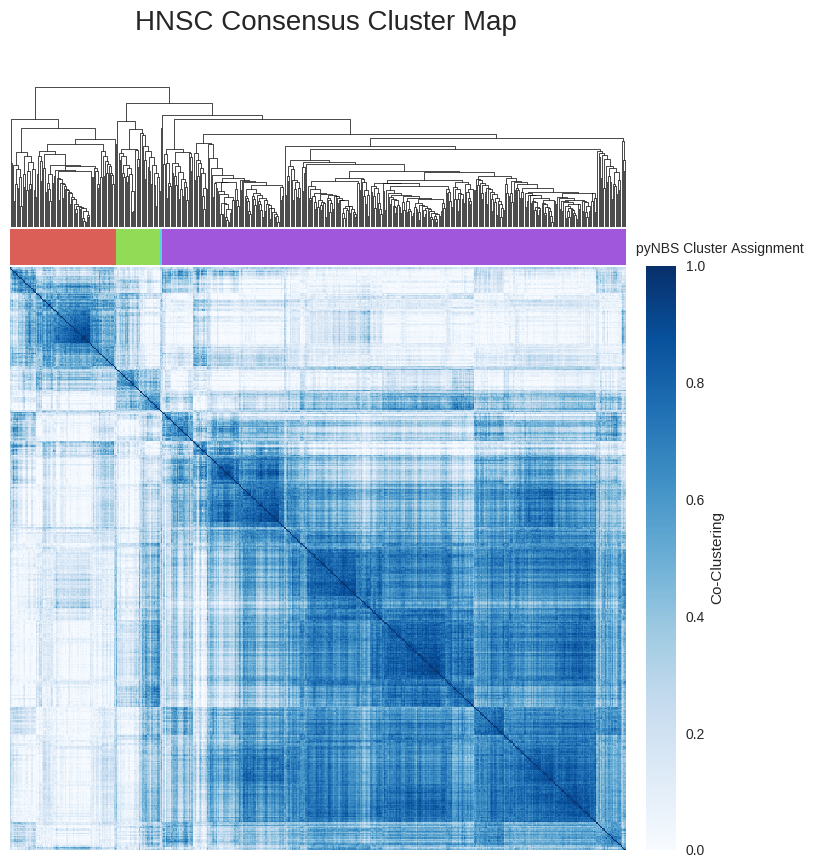

In [31]:
Image(filename = run_pyNBS_params['save_co_cluster_map'], width=600, height=600)

Multi-Class Log-Rank P: 0.357001516301


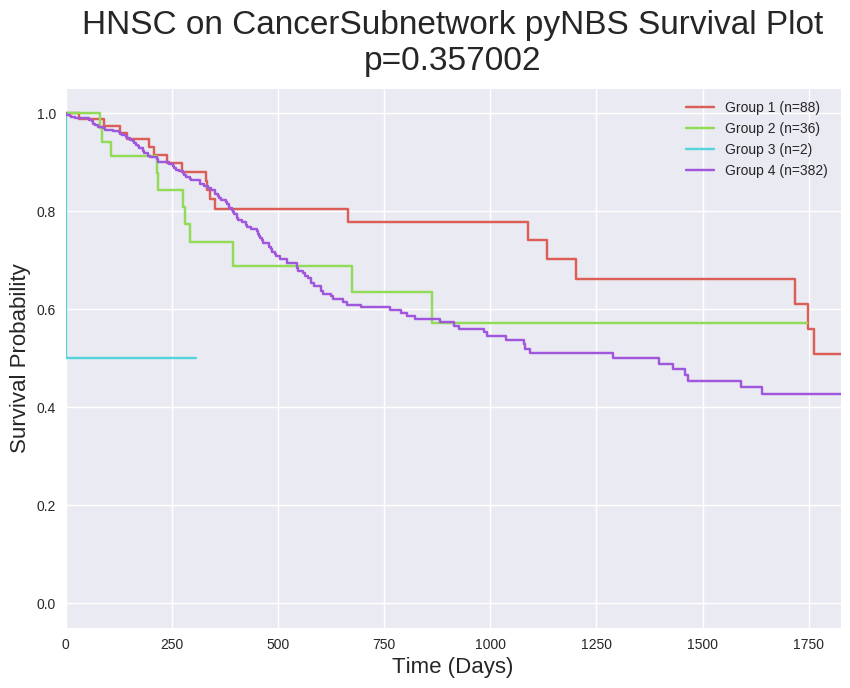

In [32]:
clin_path = '/cellar/users/t1jia/pyNBS/data/Clinical_Files/HNSC.clin.merged.surv.txt'
plot.cluster_KMplot(NBS_cluster_assign,clin_path,title='HNSC on CancerSubnetwork pyNBS Survival Plot', save_path = run_pyNBS_params['save_km_plot'])
Image(filename = run_pyNBS_params['save_km_plot'], width=600, height=600)

## No Propagation

In [83]:
run_pyNBS_params = {'verbose' : True,
                    
                    ##### Path for HNSC #####
                    # Data used in this notebook is located in /data folder in the repository.
                    # To run this notebook, please modify the path to indicate your local directory.
                    # If you would like to use your own data file, 
                    # please refer to the "Load data" cell below for formatting details.
                     
                    # Please make sure you modify file path for loading/saving to indicate your local directory                 
                    'sm_data_file' : '/cellar/users/t1jia/pyNBS/data/Mutation_Files/HNSC_sm_data.txt',
                    'network_path' : '/cellar/users/t1jia/pyNBS/data/Network_Files/CancerSubnetwork.txt',
                    
                    'mut_filetype' : 'list',
                    'mut_filedelim' : '\t',
                    'net_filedelim' : '\t',
                    'degree_preserved_shuffle' : False,
                    'node_label_shuffle' : False,
                    
                    'regularize_network' : True,
                    'reg_net_gamma' : 0.01,
                    'k_nearest_neighbors' : 11,
                    'save_knn_glap' : None,
                    'regularization_network_graph_laplacian_file' : None,
                    'niter' : 100, 
                    'calculate_propagation_kernel' : True,
                    
                    'propagation_kernel_file' : None,
                    'save_kernel' : None,
                    'save_H' : None,
                    'consensus_cluster' : True,
                    'assign_clusters' : True,
                    'save_co_cluster_matrix' : '/cellar/users/t1jia/pyNBS/Supplementary_Notebooks/results/no_prop/HNSC_co_cluster_matrix.csv',
                    'save_cluster_assignments' : '/cellar/users/t1jia/pyNBS/Supplementary_Notebooks/results/no_prop/HNSC_cluster_assignment.csv',
                    'plot_co_cluster_map' : True,
                    'plot_title' : 'HNSC Consensus Cluster Map',
                    'save_co_cluster_map' : '/cellar/users/t1jia/pyNBS/Supplementary_Notebooks/results/no_prop/HNSC_co_cluster.png',
                    'save_km_plot' : '/cellar/users/t1jia/pyNBS/Supplementary_Notebooks/results/no_prop/HNSC_KM_plot.png'
                    }

In [84]:
NBS_options = {'pats_subsample_p' : 0.8, 
               'gene_subsample_p' : 0.8, 
               'min_muts' : 10,
               'prop_data' : False, 
               'prop_alpha' : 0.7, 
               'prop_symmetric_norm' : False, 
               'qnorm_data' : True,
               'netNMF_k' : 4, 
               'netNMF_gamma' : 200, 
               'netNMF_update_gamma' : False, 
               'netNMF_gamma_factor' : 1,
               'netNMF_niter' : 250, 
               'netNMF_eps' : 1e-15, 
               'netNMF_err_tol' : 1e-4, 
               'netNMF_err_delta_tol' : 1e-8}

In [85]:
# Load somatic mutation data
sm_mat = dit.load_binary_mutation_data(run_pyNBS_params['sm_data_file'], filetype=run_pyNBS_params['mut_filetype'], delimiter=run_pyNBS_params['mut_filedelim'], verbose=run_pyNBS_params['verbose'])
# Load network
network = dit.load_network_file(run_pyNBS_params['network_path'], delimiter=run_pyNBS_params['net_filedelim'], degree_shuffle=run_pyNBS_params['degree_preserved_shuffle'], 
                                label_shuffle=run_pyNBS_params['node_label_shuffle'], verbose=run_pyNBS_params['verbose'])


Binary Mutation Matrix Loaded: /cellar/users/t1jia/pyNBS/data/Mutation_Files/HNSC_sm_data.txt
Network File Loaded: /cellar/users/t1jia/pyNBS/data/Network_Files/CancerSubnetwork.txt


In [86]:
# Get knnGlap
if run_pyNBS_params['regularize_network']:
    knnGlap = core.network_inf_KNN_glap(network, gamma=run_pyNBS_params['reg_net_gamma'], kn=run_pyNBS_params['k_nearest_neighbors'], verbose=run_pyNBS_params['verbose'], save_path=run_pyNBS_params['save_knn_glap'])
else:
    # Load propatagion kernel
    if run_pyNBS_params['regularization_network_graph_laplacian_file'].endswith('.hdf'):
        knnGlap = pd.read_hdf(run_pyNBS_params['regularization_network_graph_laplacian_file'])
    else:
        knnGlap = pd.read_csv(run_pyNBS_params['regularization_network_graph_laplacian_file'])
    if run_pyNBS_params['verbose']:
        print 'Pre-calculated regularization network graph laplacian loaded'

Graph influence matrix calculated: 1.49826788902 seconds
Graph laplacian of KNN network from influence matrix calculated: 5.89957404137 seconds


In [87]:
# Get network propagation kernel
if run_pyNBS_params['propagation_kernel_file'] is not None:
    # Load propagation kernel
    if run_pyNBS_params['propagation_kernel_file'].endswith('.hdf'):
        kernel = pd.read_hdf(run_pyNBS_params['propagation_kernel_file'])
    else:
        kernel = pd.read_csv(run_pyNBS_params['propagation_kernel_file'])
    if run_pyNBS_params['verbose']:
        print 'Pre-calculated network kernel loaded'
else:
    if run_pyNBS_params['calculate_propagation_kernel']:
        # Calculate propagation kernel by propagating identity matrix of network
        network_nodes = network.nodes()
        network_I = pd.DataFrame(np.identity(len(network_nodes)), index=network_nodes, columns=network_nodes)
        kernel = prop.network_propagation(network, network_I, NBS_options['prop_alpha'], symmetric_norm=NBS_options['prop_symmetric_norm'], verbose=run_pyNBS_params['verbose'], save_path=run_pyNBS_params['save_kernel'])  
        if run_pyNBS_params['verbose']:
            print 'Network kernel calculated'
    else:
        kernel = None
        if run_pyNBS_params['verbose']:
            print 'No network kernel established'

Performing network propagation with alpha: 0.7
Network Propagation Complete: 3.80721092224 seconds
Network kernel calculated


In [88]:
Hlist = []
for i in range(run_pyNBS_params['niter']):
    netNMF_time = time.time()
    Hlist.append(pyNBS_single.NBS_single(sm_mat, NBS_options, propNet=network, propNet_kernel=kernel, regNet_glap=knnGlap, verbose=False, save_path=run_pyNBS_params['save_H']))
    if run_pyNBS_params['verbose']:
        t = time.time()-netNMF_time
        print 'NBS iteration:', i+1, 'complete:', t, 'seconds'

Somatic mutation data not propagated
NBS iteration: 1 complete: 24.5964250565 seconds
Somatic mutation data not propagated
NBS iteration: 2 complete: 23.7539470196 seconds
Somatic mutation data not propagated
NBS iteration: 3 complete: 24.0697128773 seconds
Somatic mutation data not propagated
NBS iteration: 4 complete: 25.153799057 seconds
Somatic mutation data not propagated
NBS iteration: 5 complete: 24.5265450478 seconds
Somatic mutation data not propagated
NBS iteration: 6 complete: 21.6738359928 seconds
Somatic mutation data not propagated
NBS iteration: 7 complete: 24.3551709652 seconds
Somatic mutation data not propagated
NBS iteration: 8 complete: 23.6828951836 seconds
Somatic mutation data not propagated
NBS iteration: 9 complete: 22.9309179783 seconds
Somatic mutation data not propagated
NBS iteration: 10 complete: 21.4609820843 seconds
Somatic mutation data not propagated
NBS iteration: 11 complete: 22.0501048565 seconds
Somatic mutation data not propagated
NBS iteration: 1

NBS iteration: 95 complete: 22.6597559452 seconds
Somatic mutation data not propagated
NBS iteration: 96 complete: 21.8213980198 seconds
Somatic mutation data not propagated
NBS iteration: 97 complete: 21.5209710598 seconds
Somatic mutation data not propagated
NBS iteration: 98 complete: 24.4647619724 seconds
Somatic mutation data not propagated
NBS iteration: 99 complete: 27.4934279919 seconds
Somatic mutation data not propagated
NBS iteration: 100 complete: 32.3250300884 seconds


In [89]:
if run_pyNBS_params['consensus_cluster']:
    NBS_cc_table, NBS_cc_linkage, NBS_cluster_assign = cc.consensus_hclust_hard(Hlist, NBS_options['netNMF_k'], assign_cluster=run_pyNBS_params['assign_clusters'])
    if run_pyNBS_params['verbose']:
        print 'Consensus Clustering complete'        
    if run_pyNBS_params['save_co_cluster_matrix'] is not None:
        NBS_cc_table.to_csv(run_pyNBS_params['save_co_cluster_matrix'])
        if run_pyNBS_params['verbose']:
            print 'Co-clustering matrix saved'
    if run_pyNBS_params['save_cluster_assignments'] is not None:
        NBS_cluster_assign.to_csv(run_pyNBS_params['save_cluster_assignments'])
        if run_pyNBS_params['verbose']:
            print 'Cluster assignments saved'

Consensus Clustering complete
Co-clustering matrix saved
Cluster assignments saved


In [90]:
# Plot Consensus Cluster Map
if run_pyNBS_params['plot_co_cluster_map']:
    NBS_cluster_assign_cmap = plot.cluster_color_assign(NBS_cluster_assign, name='pyNBS Cluster Assignment')
    plot.plot_cc_map(NBS_cc_table, NBS_cc_linkage, title=run_pyNBS_params['plot_title'], row_color_map=None, 
                     col_color_map=NBS_cluster_assign_cmap, save_path=run_pyNBS_params['save_co_cluster_map'])
    if run_pyNBS_params['verbose']:
        print 'Consensus Clustering map saved'

Consensus Clustering map saved


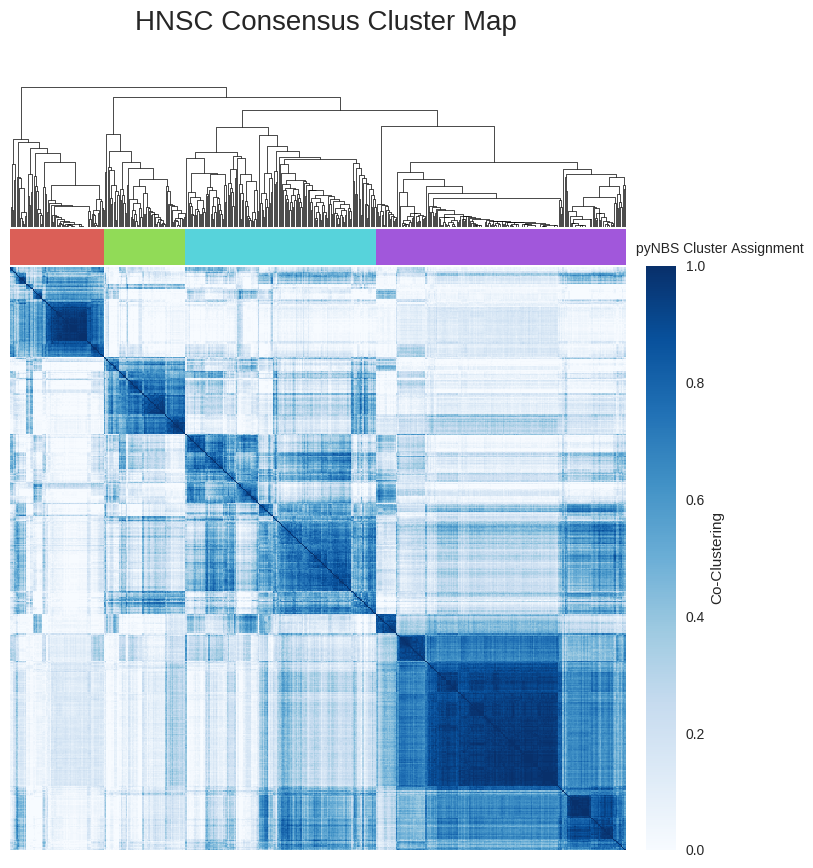

In [91]:
Image(filename = run_pyNBS_params['save_co_cluster_map'], width=600, height=600)

Multi-Class Log-Rank P: 0.861696323393


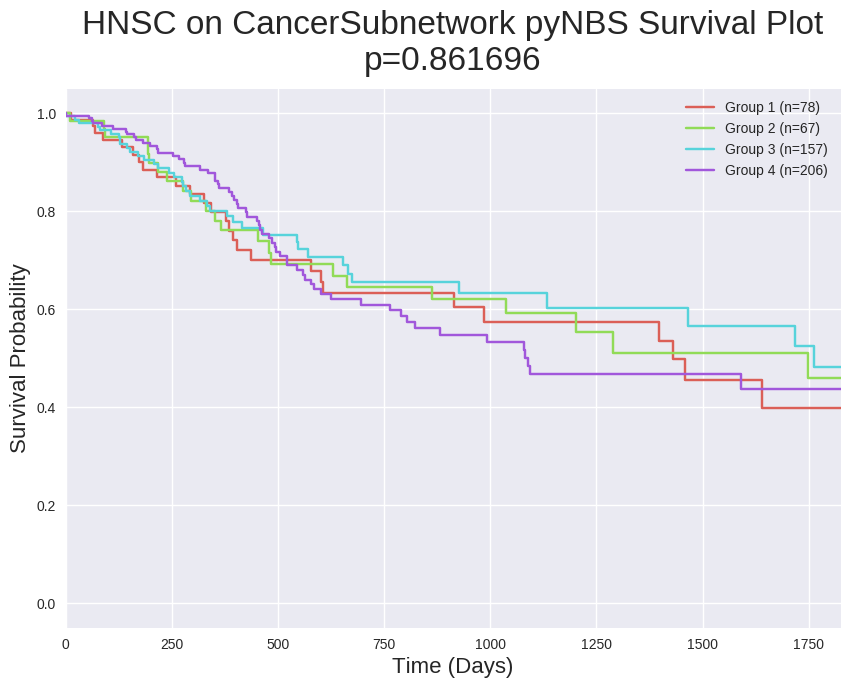

In [92]:
clin_path = '/cellar/users/t1jia/pyNBS/data/Clinical_Files/HNSC.clin.merged.surv.txt'
plot.cluster_KMplot(NBS_cluster_assign,clin_path,title='HNSC on CancerSubnetwork pyNBS Survival Plot', save_path = run_pyNBS_params['save_km_plot'])
Image(filename = run_pyNBS_params['save_km_plot'], width=600, height=600)

## Symetric degree norm

In [43]:
run_pyNBS_params = {'verbose' : True,
                    
                    ##### Path for HNSC #####
                    # Data used in this notebook is located in /data folder in the repository.
                    # To run this notebook, please modify the path to indicate your local directory.
                    # If you would like to use your own data file, 
                    # please refer to the "Load data" cell below for formatting details.
                     
                    # Please make sure you modify file path for loading/saving to indicate your local directory                 
                    'sm_data_file' : '/cellar/users/t1jia/pyNBS/data/Mutation_Files/HNSC_sm_data.txt',
                    'network_path' : '/cellar/users/t1jia/pyNBS/data/Network_Files/CancerSubnetwork.txt',
                    
                    'mut_filetype' : 'list',
                    'mut_filedelim' : '\t',
                    'net_filedelim' : '\t',
                    'degree_preserved_shuffle' : False,
                    'node_label_shuffle' : False,
                    
                    'regularize_network' : True,
                    'reg_net_gamma' : 0.01,
                    'k_nearest_neighbors' : 11,
                    'save_knn_glap' : None,
                    'regularization_network_graph_laplacian_file' : None,
                    'niter' : 100, 
                    'calculate_propagation_kernel' : True,
                    
                    'propagation_kernel_file' : None,
                    'save_kernel' : None,
                    'save_H' : None,
                    'consensus_cluster' : True,
                    'assign_clusters' : True,
                    'save_co_cluster_matrix' : '/cellar/users/t1jia/pyNBS/Supplementary_Notebooks/results/symetric_norm/HNSC_co_cluster_matrix.csv',
                    'save_cluster_assignments' : '/cellar/users/t1jia/pyNBS/Supplementary_Notebooks/results/symetric_norm/HNSC_cluster_assignment.csv',
                    'plot_co_cluster_map' : True,
                    'plot_title' : 'HNSC Consensus Cluster Map',
                    'save_co_cluster_map' : '/cellar/users/t1jia/pyNBS/Supplementary_Notebooks/results/symetric_norm/HNSC_co_cluster.png',
                    'save_km_plot' : '/cellar/users/t1jia/pyNBS/Supplementary_Notebooks/results/symetric_norm/HNSC_KM_plot.png'
                    }

In [44]:
NBS_options = {'pats_subsample_p' : 0.8, 
               'gene_subsample_p' : 0.8, 
               'min_muts' : 10,
               'prop_data' : True, 
               'prop_alpha' : 0.7, 
               'prop_symmetric_norm' : True, #### 
               'qnorm_data' : True,
               'netNMF_k' : 4, 
               'netNMF_gamma' : 200, 
               'netNMF_update_gamma' : False, 
               'netNMF_gamma_factor' : 1,
               'netNMF_niter' : 250, 
               'netNMF_eps' : 1e-15, 
               'netNMF_err_tol' : 1e-4, 
               'netNMF_err_delta_tol' : 1e-8}

In [45]:
# Load somatic mutation data
sm_mat = dit.load_binary_mutation_data(run_pyNBS_params['sm_data_file'], filetype=run_pyNBS_params['mut_filetype'], delimiter=run_pyNBS_params['mut_filedelim'], verbose=run_pyNBS_params['verbose'])
# Load network
network = dit.load_network_file(run_pyNBS_params['network_path'], delimiter=run_pyNBS_params['net_filedelim'], degree_shuffle=run_pyNBS_params['degree_preserved_shuffle'], 
                                label_shuffle=run_pyNBS_params['node_label_shuffle'], verbose=run_pyNBS_params['verbose'])


Binary Mutation Matrix Loaded: /cellar/users/t1jia/pyNBS/data/Mutation_Files/HNSC_sm_data.txt
Network File Loaded: /cellar/users/t1jia/pyNBS/data/Network_Files/CancerSubnetwork.txt


In [46]:
# Get knnGlap
if run_pyNBS_params['regularize_network']:
    knnGlap = core.network_inf_KNN_glap(network, gamma=run_pyNBS_params['reg_net_gamma'], kn=run_pyNBS_params['k_nearest_neighbors'], verbose=run_pyNBS_params['verbose'], save_path=run_pyNBS_params['save_knn_glap'])
else:
    # Load propatagion kernel
    if run_pyNBS_params['regularization_network_graph_laplacian_file'].endswith('.hdf'):
        knnGlap = pd.read_hdf(run_pyNBS_params['regularization_network_graph_laplacian_file'])
    else:
        knnGlap = pd.read_csv(run_pyNBS_params['regularization_network_graph_laplacian_file'])
    if run_pyNBS_params['verbose']:
        print 'Pre-calculated regularization network graph laplacian loaded'

Graph influence matrix calculated: 2.0216050148 seconds
Graph laplacian of KNN network from influence matrix calculated: 4.73602795601 seconds


In [47]:
# Get network propagation kernel
if run_pyNBS_params['propagation_kernel_file'] is not None:
    # Load propagation kernel
    if run_pyNBS_params['propagation_kernel_file'].endswith('.hdf'):
        kernel = pd.read_hdf(run_pyNBS_params['propagation_kernel_file'])
    else:
        kernel = pd.read_csv(run_pyNBS_params['propagation_kernel_file'])
    if run_pyNBS_params['verbose']:
        print 'Pre-calculated network kernel loaded'
else:
    if run_pyNBS_params['calculate_propagation_kernel']:
        # Calculate propagation kernel by propagating identity matrix of network
        network_nodes = network.nodes()
        network_I = pd.DataFrame(np.identity(len(network_nodes)), index=network_nodes, columns=network_nodes)
        kernel = prop.network_propagation(network, network_I, NBS_options['prop_alpha'], symmetric_norm=NBS_options['prop_symmetric_norm'], verbose=run_pyNBS_params['verbose'], save_path=run_pyNBS_params['save_kernel'])  
        if run_pyNBS_params['verbose']:
            print 'Network kernel calculated'
    else:
        kernel = None
        if run_pyNBS_params['verbose']:
            print 'No network kernel established'

Performing network propagation with alpha: 0.7
Network Propagation Complete: 4.37149000168 seconds
Network kernel calculated


In [48]:
Hlist = []
for i in range(run_pyNBS_params['niter']):
    netNMF_time = time.time()
    Hlist.append(pyNBS_single.NBS_single(sm_mat, NBS_options, propNet=network, propNet_kernel=kernel, regNet_glap=knnGlap, verbose=False, save_path=run_pyNBS_params['save_H']))
    if run_pyNBS_params['verbose']:
        t = time.time()-netNMF_time
        print 'NBS iteration:', i+1, 'complete:', t, 'seconds'

NBS iteration: 1 complete: 22.3878409863 seconds
NBS iteration: 2 complete: 22.2193770409 seconds
NBS iteration: 3 complete: 22.189606905 seconds
NBS iteration: 4 complete: 22.3559949398 seconds
NBS iteration: 5 complete: 22.3056578636 seconds
NBS iteration: 6 complete: 22.3406960964 seconds
NBS iteration: 7 complete: 22.3118560314 seconds
NBS iteration: 8 complete: 22.2715280056 seconds
NBS iteration: 9 complete: 22.3376860619 seconds
NBS iteration: 10 complete: 22.0691468716 seconds
NBS iteration: 11 complete: 22.2015910149 seconds
NBS iteration: 12 complete: 22.407834053 seconds
NBS iteration: 13 complete: 22.3078680038 seconds
NBS iteration: 14 complete: 22.2149879932 seconds
NBS iteration: 15 complete: 22.2894020081 seconds
NBS iteration: 16 complete: 22.2561981678 seconds
NBS iteration: 17 complete: 22.2393438816 seconds
NBS iteration: 18 complete: 22.2346248627 seconds
NBS iteration: 19 complete: 22.1927969456 seconds
NBS iteration: 20 complete: 22.3738632202 seconds
NBS iterati

In [49]:
if run_pyNBS_params['consensus_cluster']:
    NBS_cc_table, NBS_cc_linkage, NBS_cluster_assign = cc.consensus_hclust_hard(Hlist, NBS_options['netNMF_k'], assign_cluster=run_pyNBS_params['assign_clusters'])
    if run_pyNBS_params['verbose']:
        print 'Consensus Clustering complete'        
    if run_pyNBS_params['save_co_cluster_matrix'] is not None:
        NBS_cc_table.to_csv(run_pyNBS_params['save_co_cluster_matrix'])
        if run_pyNBS_params['verbose']:
            print 'Co-clustering matrix saved'
    if run_pyNBS_params['save_cluster_assignments'] is not None:
        NBS_cluster_assign.to_csv(run_pyNBS_params['save_cluster_assignments'])
        if run_pyNBS_params['verbose']:
            print 'Cluster assignments saved'

Consensus Clustering complete
Co-clustering matrix saved
Cluster assignments saved


In [50]:
# Plot Consensus Cluster Map
if run_pyNBS_params['plot_co_cluster_map']:
    NBS_cluster_assign_cmap = plot.cluster_color_assign(NBS_cluster_assign, name='pyNBS Cluster Assignment')
    plot.plot_cc_map(NBS_cc_table, NBS_cc_linkage, title=run_pyNBS_params['plot_title'], row_color_map=None, 
                     col_color_map=NBS_cluster_assign_cmap, save_path=run_pyNBS_params['save_co_cluster_map'])
    if run_pyNBS_params['verbose']:
        print 'Consensus Clustering map saved'

Consensus Clustering map saved


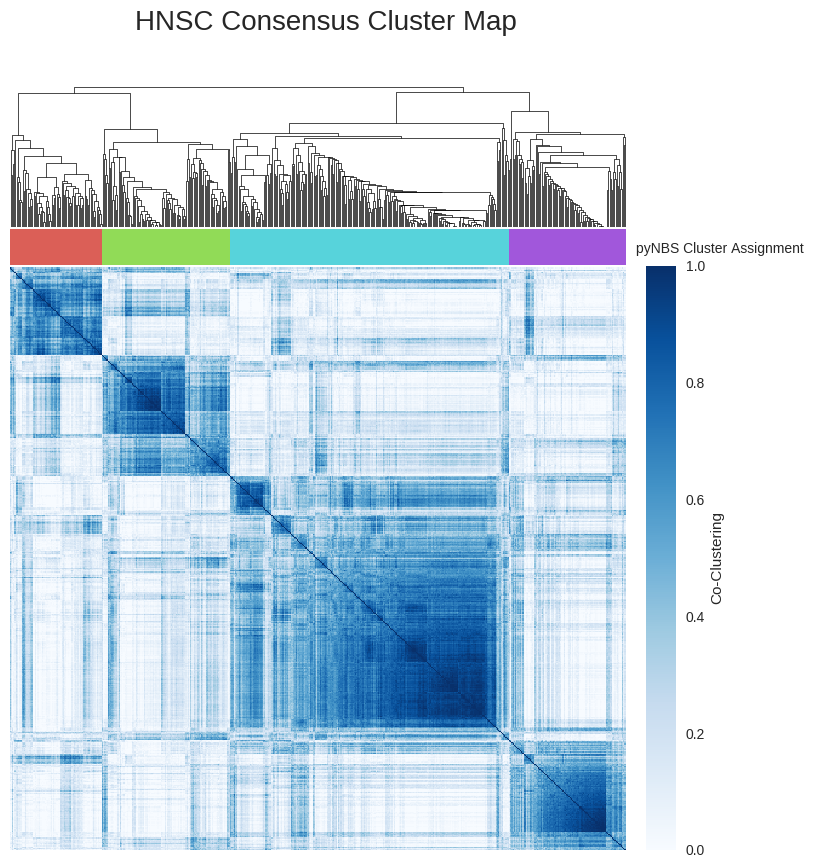

In [51]:
Image(filename = run_pyNBS_params['save_co_cluster_map'], width=600, height=600)

Multi-Class Log-Rank P: 0.0643001902391


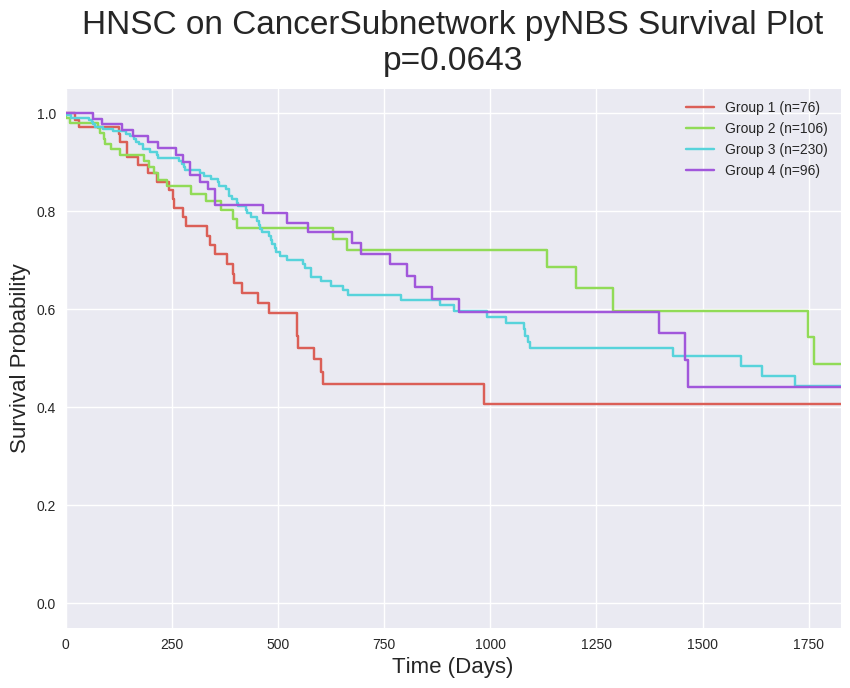

In [52]:
clin_path = '/cellar/users/t1jia/pyNBS/data/Clinical_Files/HNSC.clin.merged.surv.txt'
plot.cluster_KMplot(NBS_cluster_assign,clin_path,title='HNSC on CancerSubnetwork pyNBS Survival Plot', save_path = run_pyNBS_params['save_km_plot'])
Image(filename = run_pyNBS_params['save_km_plot'], width=600, height=600)

## Subsampling 50%

In [53]:
run_pyNBS_params = {'verbose' : True,
                    
                    ##### Path for HNSC #####
                    # Data used in this notebook is located in /data folder in the repository.
                    # To run this notebook, please modify the path to indicate your local directory.
                    # If you would like to use your own data file, 
                    # please refer to the "Load data" cell below for formatting details.
                     
                    # Please make sure you modify file path for loading/saving to indicate your local directory                 
                    'sm_data_file' : '/cellar/users/t1jia/pyNBS/data/Mutation_Files/HNSC_sm_data.txt',
                    'network_path' : '/cellar/users/t1jia/pyNBS/data/Network_Files/CancerSubnetwork.txt',
                    
                    'mut_filetype' : 'list',
                    'mut_filedelim' : '\t',
                    'net_filedelim' : '\t',
                    'degree_preserved_shuffle' : False,
                    'node_label_shuffle' : False,
                    
                    'regularize_network' : True,
                    'reg_net_gamma' : 0.01,
                    'k_nearest_neighbors' : 11,
                    'save_knn_glap' : None,
                    'regularization_network_graph_laplacian_file' : None,
                    'niter' : 100, 
                    'calculate_propagation_kernel' : True,
                    
                    'propagation_kernel_file' : None,
                    'save_kernel' : None,
                    'save_H' : None,
                    'consensus_cluster' : True,
                    'assign_clusters' : True,
                    'save_co_cluster_matrix' : '/cellar/users/t1jia/pyNBS/Supplementary_Notebooks/results/subsample_50/HNSC_co_cluster_matrix.csv',
                    'save_cluster_assignments' : '/cellar/users/t1jia/pyNBS/Supplementary_Notebooks/results/subsample_50/HNSC_cluster_assignment.csv',
                    'plot_co_cluster_map' : True,
                    'plot_title' : 'HNSC Consensus Cluster Map',
                    'save_co_cluster_map' : '/cellar/users/t1jia/pyNBS/Supplementary_Notebooks/results/subsample_50/HNSC_co_cluster.png',
                    'save_km_plot' : '/cellar/users/t1jia/pyNBS/Supplementary_Notebooks/results/subsample_50/HNSC_KM_plot.png'
                    }

In [54]:
NBS_options = {'pats_subsample_p' : 0.5, ####
               'gene_subsample_p' : 0.5, ####
               'min_muts' : 10,
               'prop_data' : True, 
               'prop_alpha' : 0.7, 
               'prop_symmetric_norm' : False, 
               'qnorm_data' : True,
               'netNMF_k' : 4, 
               'netNMF_gamma' : 200, 
               'netNMF_update_gamma' : False, 
               'netNMF_gamma_factor' : 1,
               'netNMF_niter' : 250, 
               'netNMF_eps' : 1e-15, 
               'netNMF_err_tol' : 1e-4, 
               'netNMF_err_delta_tol' : 1e-8}

In [55]:
# Load somatic mutation data
sm_mat = dit.load_binary_mutation_data(run_pyNBS_params['sm_data_file'], filetype=run_pyNBS_params['mut_filetype'], delimiter=run_pyNBS_params['mut_filedelim'], verbose=run_pyNBS_params['verbose'])
# Load network
network = dit.load_network_file(run_pyNBS_params['network_path'], delimiter=run_pyNBS_params['net_filedelim'], degree_shuffle=run_pyNBS_params['degree_preserved_shuffle'], 
                                label_shuffle=run_pyNBS_params['node_label_shuffle'], verbose=run_pyNBS_params['verbose'])


Binary Mutation Matrix Loaded: /cellar/users/t1jia/pyNBS/data/Mutation_Files/HNSC_sm_data.txt
Network File Loaded: /cellar/users/t1jia/pyNBS/data/Network_Files/CancerSubnetwork.txt


In [56]:
# Get knnGlap
if run_pyNBS_params['regularize_network']:
    knnGlap = core.network_inf_KNN_glap(network, gamma=run_pyNBS_params['reg_net_gamma'], kn=run_pyNBS_params['k_nearest_neighbors'], verbose=run_pyNBS_params['verbose'], save_path=run_pyNBS_params['save_knn_glap'])
else:
    # Load propatagion kernel
    if run_pyNBS_params['regularization_network_graph_laplacian_file'].endswith('.hdf'):
        knnGlap = pd.read_hdf(run_pyNBS_params['regularization_network_graph_laplacian_file'])
    else:
        knnGlap = pd.read_csv(run_pyNBS_params['regularization_network_graph_laplacian_file'])
    if run_pyNBS_params['verbose']:
        print 'Pre-calculated regularization network graph laplacian loaded'

Graph influence matrix calculated: 1.63847398758 seconds
Graph laplacian of KNN network from influence matrix calculated: 4.66807198524 seconds


In [57]:
# Get network propagation kernel
if run_pyNBS_params['propagation_kernel_file'] is not None:
    # Load propagation kernel
    if run_pyNBS_params['propagation_kernel_file'].endswith('.hdf'):
        kernel = pd.read_hdf(run_pyNBS_params['propagation_kernel_file'])
    else:
        kernel = pd.read_csv(run_pyNBS_params['propagation_kernel_file'])
    if run_pyNBS_params['verbose']:
        print 'Pre-calculated network kernel loaded'
else:
    if run_pyNBS_params['calculate_propagation_kernel']:
        # Calculate propagation kernel by propagating identity matrix of network
        network_nodes = network.nodes()
        network_I = pd.DataFrame(np.identity(len(network_nodes)), index=network_nodes, columns=network_nodes)
        kernel = prop.network_propagation(network, network_I, NBS_options['prop_alpha'], symmetric_norm=NBS_options['prop_symmetric_norm'], verbose=run_pyNBS_params['verbose'], save_path=run_pyNBS_params['save_kernel'])  
        if run_pyNBS_params['verbose']:
            print 'Network kernel calculated'
    else:
        kernel = None
        if run_pyNBS_params['verbose']:
            print 'No network kernel established'

Performing network propagation with alpha: 0.7
Network Propagation Complete: 4.11346697807 seconds
Network kernel calculated


In [58]:
Hlist = []
for i in range(run_pyNBS_params['niter']):
    netNMF_time = time.time()
    Hlist.append(pyNBS_single.NBS_single(sm_mat, NBS_options, propNet=network, propNet_kernel=kernel, regNet_glap=knnGlap, verbose=False, save_path=run_pyNBS_params['save_H']))
    if run_pyNBS_params['verbose']:
        t = time.time()-netNMF_time
        print 'NBS iteration:', i+1, 'complete:', t, 'seconds'

NBS iteration: 1 complete: 15.1108160019 seconds
NBS iteration: 2 complete: 15.0775740147 seconds
NBS iteration: 3 complete: 14.9209589958 seconds
NBS iteration: 4 complete: 14.6867001057 seconds
NBS iteration: 5 complete: 14.7894449234 seconds
NBS iteration: 6 complete: 15.0198760033 seconds
NBS iteration: 7 complete: 14.923789978 seconds
NBS iteration: 8 complete: 15.0486440659 seconds
NBS iteration: 9 complete: 14.7879018784 seconds
NBS iteration: 10 complete: 14.8773519993 seconds
NBS iteration: 11 complete: 15.0712039471 seconds
NBS iteration: 12 complete: 15.0217049122 seconds
NBS iteration: 13 complete: 14.9437348843 seconds
NBS iteration: 14 complete: 14.720995903 seconds
NBS iteration: 15 complete: 14.7980968952 seconds
NBS iteration: 16 complete: 14.7401480675 seconds
NBS iteration: 17 complete: 14.7565591335 seconds
NBS iteration: 18 complete: 14.7103939056 seconds
NBS iteration: 19 complete: 15.1094548702 seconds
NBS iteration: 20 complete: 15.1157720089 seconds
NBS iterati

In [59]:
if run_pyNBS_params['consensus_cluster']:
    NBS_cc_table, NBS_cc_linkage, NBS_cluster_assign = cc.consensus_hclust_hard(Hlist, NBS_options['netNMF_k'], assign_cluster=run_pyNBS_params['assign_clusters'])
    if run_pyNBS_params['verbose']:
        print 'Consensus Clustering complete'        
    if run_pyNBS_params['save_co_cluster_matrix'] is not None:
        NBS_cc_table.to_csv(run_pyNBS_params['save_co_cluster_matrix'])
        if run_pyNBS_params['verbose']:
            print 'Co-clustering matrix saved'
    if run_pyNBS_params['save_cluster_assignments'] is not None:
        NBS_cluster_assign.to_csv(run_pyNBS_params['save_cluster_assignments'])
        if run_pyNBS_params['verbose']:
            print 'Cluster assignments saved'

Consensus Clustering complete
Co-clustering matrix saved
Cluster assignments saved


In [60]:
# Plot Consensus Cluster Map
if run_pyNBS_params['plot_co_cluster_map']:
    NBS_cluster_assign_cmap = plot.cluster_color_assign(NBS_cluster_assign, name='pyNBS Cluster Assignment')
    plot.plot_cc_map(NBS_cc_table, NBS_cc_linkage, title=run_pyNBS_params['plot_title'], row_color_map=None, 
                     col_color_map=NBS_cluster_assign_cmap, save_path=run_pyNBS_params['save_co_cluster_map'])
    if run_pyNBS_params['verbose']:
        print 'Consensus Clustering map saved'

Consensus Clustering map saved


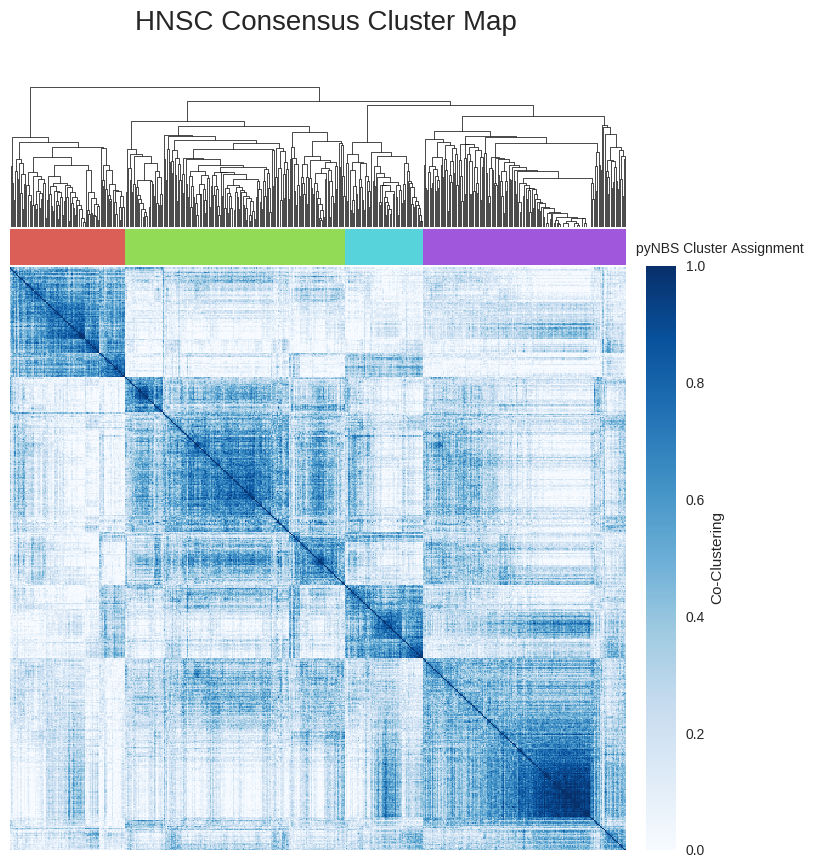

In [61]:
Image(filename = run_pyNBS_params['save_co_cluster_map'], width=600, height=600)

Multi-Class Log-Rank P: 0.0259603682569


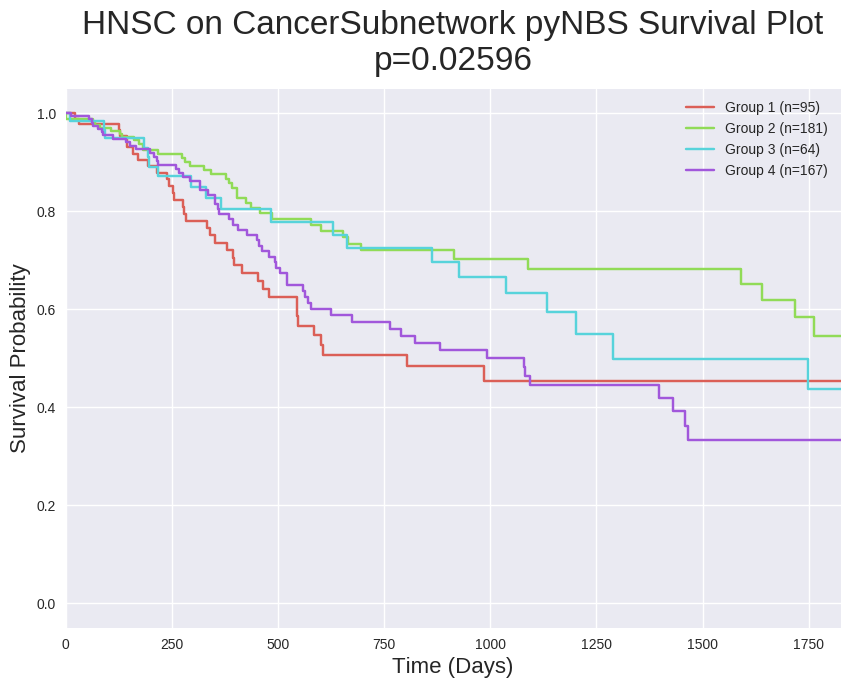

In [62]:
clin_path = '/cellar/users/t1jia/pyNBS/data/Clinical_Files/HNSC.clin.merged.surv.txt'
plot.cluster_KMplot(NBS_cluster_assign,clin_path,title='HNSC on CancerSubnetwork pyNBS Survival Plot', save_path = run_pyNBS_params['save_km_plot'])
Image(filename = run_pyNBS_params['save_km_plot'], width=600, height=600)

## k = 5

In [63]:
run_pyNBS_params = {'verbose' : True,
                    
                    ##### Path for HNSC #####
                    # Data used in this notebook is located in /data folder in the repository.
                    # To run this notebook, please modify the path to indicate your local directory.
                    # If you would like to use your own data file, 
                    # please refer to the "Load data" cell below for formatting details.
                     
                    # Please make sure you modify file path for loading/saving to indicate your local directory                 
                    'sm_data_file' : '/cellar/users/t1jia/pyNBS/data/Mutation_Files/HNSC_sm_data.txt',
                    'network_path' : '/cellar/users/t1jia/pyNBS/data/Network_Files/CancerSubnetwork.txt',
                    
                    'mut_filetype' : 'list',
                    'mut_filedelim' : '\t',
                    'net_filedelim' : '\t',
                    'degree_preserved_shuffle' : False,
                    'node_label_shuffle' : False,
                    
                    'regularize_network' : True,
                    'reg_net_gamma' : 0.01,
                    'k_nearest_neighbors' : 11,
                    'save_knn_glap' : None,
                    'regularization_network_graph_laplacian_file' : None,
                    'niter' : 100, 
                    'calculate_propagation_kernel' : True,
                    
                    'propagation_kernel_file' : None,
                    'save_kernel' : None,
                    'save_H' : None,
                    'consensus_cluster' : True,
                    'assign_clusters' : True,
                    'save_co_cluster_matrix' : '/cellar/users/t1jia/pyNBS/Supplementary_Notebooks/results/k/HNSC_co_cluster_matrix.csv',
                    'save_cluster_assignments' : '/cellar/users/t1jia/pyNBS/Supplementary_Notebooks/results/k/HNSC_cluster_assignment.csv',
                    'plot_co_cluster_map' : True,
                    'plot_title' : 'HNSC Consensus Cluster Map',
                    'save_co_cluster_map' : '/cellar/users/t1jia/pyNBS/Supplementary_Notebooks/results/k/HNSC_co_cluster.png',
                    'save_km_plot' : '/cellar/users/t1jia/pyNBS/Supplementary_Notebooks/results/k/HNSC_KM_plot.png'
                    }

In [64]:
NBS_options = {'pats_subsample_p' : 0.8, 
               'gene_subsample_p' : 0.8, 
               'min_muts' : 10,
               'prop_data' : True, 
               'prop_alpha' : 0.7, 
               'prop_symmetric_norm' : False, 
               'qnorm_data' : True,
               'netNMF_k' : 5, 
               'netNMF_gamma' : 200, 
               'netNMF_update_gamma' : False, 
               'netNMF_gamma_factor' : 1,
               'netNMF_niter' : 250, 
               'netNMF_eps' : 1e-15, 
               'netNMF_err_tol' : 1e-4, 
               'netNMF_err_delta_tol' : 1e-8}

In [65]:
# Load somatic mutation data
sm_mat = dit.load_binary_mutation_data(run_pyNBS_params['sm_data_file'], filetype=run_pyNBS_params['mut_filetype'], delimiter=run_pyNBS_params['mut_filedelim'], verbose=run_pyNBS_params['verbose'])
# Load network
network = dit.load_network_file(run_pyNBS_params['network_path'], delimiter=run_pyNBS_params['net_filedelim'], degree_shuffle=run_pyNBS_params['degree_preserved_shuffle'], 
                                label_shuffle=run_pyNBS_params['node_label_shuffle'], verbose=run_pyNBS_params['verbose'])


Binary Mutation Matrix Loaded: /cellar/users/t1jia/pyNBS/data/Mutation_Files/HNSC_sm_data.txt
Network File Loaded: /cellar/users/t1jia/pyNBS/data/Network_Files/CancerSubnetwork.txt


In [66]:
# Get knnGlap
if run_pyNBS_params['regularize_network']:
    knnGlap = core.network_inf_KNN_glap(network, gamma=run_pyNBS_params['reg_net_gamma'], kn=run_pyNBS_params['k_nearest_neighbors'], verbose=run_pyNBS_params['verbose'], save_path=run_pyNBS_params['save_knn_glap'])
else:
    # Load propatagion kernel
    if run_pyNBS_params['regularization_network_graph_laplacian_file'].endswith('.hdf'):
        knnGlap = pd.read_hdf(run_pyNBS_params['regularization_network_graph_laplacian_file'])
    else:
        knnGlap = pd.read_csv(run_pyNBS_params['regularization_network_graph_laplacian_file'])
    if run_pyNBS_params['verbose']:
        print 'Pre-calculated regularization network graph laplacian loaded'

Graph influence matrix calculated: 1.76303005219 seconds
Graph laplacian of KNN network from influence matrix calculated: 4.71021008492 seconds


In [67]:
# Get network propagation kernel
if run_pyNBS_params['propagation_kernel_file'] is not None:
    # Load propagation kernel
    if run_pyNBS_params['propagation_kernel_file'].endswith('.hdf'):
        kernel = pd.read_hdf(run_pyNBS_params['propagation_kernel_file'])
    else:
        kernel = pd.read_csv(run_pyNBS_params['propagation_kernel_file'])
    if run_pyNBS_params['verbose']:
        print 'Pre-calculated network kernel loaded'
else:
    if run_pyNBS_params['calculate_propagation_kernel']:
        # Calculate propagation kernel by propagating identity matrix of network
        network_nodes = network.nodes()
        network_I = pd.DataFrame(np.identity(len(network_nodes)), index=network_nodes, columns=network_nodes)
        kernel = prop.network_propagation(network, network_I, NBS_options['prop_alpha'], symmetric_norm=NBS_options['prop_symmetric_norm'], verbose=run_pyNBS_params['verbose'], save_path=run_pyNBS_params['save_kernel'])  
        if run_pyNBS_params['verbose']:
            print 'Network kernel calculated'
    else:
        kernel = None
        if run_pyNBS_params['verbose']:
            print 'No network kernel established'

Performing network propagation with alpha: 0.7
Network Propagation Complete: 3.96686792374 seconds
Network kernel calculated


In [68]:
Hlist = []
for i in range(run_pyNBS_params['niter']):
    netNMF_time = time.time()
    Hlist.append(pyNBS_single.NBS_single(sm_mat, NBS_options, propNet=network, propNet_kernel=kernel, regNet_glap=knnGlap, verbose=False, save_path=run_pyNBS_params['save_H']))
    if run_pyNBS_params['verbose']:
        t = time.time()-netNMF_time
        print 'NBS iteration:', i+1, 'complete:', t, 'seconds'

NBS iteration: 1 complete: 26.9916188717 seconds
NBS iteration: 2 complete: 26.8507528305 seconds
NBS iteration: 3 complete: 26.7825109959 seconds
NBS iteration: 4 complete: 26.9473659992 seconds
NBS iteration: 5 complete: 26.9032008648 seconds
NBS iteration: 6 complete: 26.9764509201 seconds
NBS iteration: 7 complete: 26.9192910194 seconds
NBS iteration: 8 complete: 26.9807779789 seconds
NBS iteration: 9 complete: 26.6225249767 seconds
NBS iteration: 10 complete: 26.9704499245 seconds
NBS iteration: 11 complete: 26.6448869705 seconds
NBS iteration: 12 complete: 26.9543030262 seconds
NBS iteration: 13 complete: 26.8559551239 seconds
NBS iteration: 14 complete: 26.6407470703 seconds
NBS iteration: 15 complete: 26.6556739807 seconds
NBS iteration: 16 complete: 26.9833798409 seconds
NBS iteration: 17 complete: 27.2381658554 seconds
NBS iteration: 18 complete: 26.6964409351 seconds
NBS iteration: 19 complete: 26.8814430237 seconds
NBS iteration: 20 complete: 26.9231989384 seconds
NBS itera

In [69]:
if run_pyNBS_params['consensus_cluster']:
    NBS_cc_table, NBS_cc_linkage, NBS_cluster_assign = cc.consensus_hclust_hard(Hlist, NBS_options['netNMF_k'], assign_cluster=run_pyNBS_params['assign_clusters'])
    if run_pyNBS_params['verbose']:
        print 'Consensus Clustering complete'        
    if run_pyNBS_params['save_co_cluster_matrix'] is not None:
        NBS_cc_table.to_csv(run_pyNBS_params['save_co_cluster_matrix'])
        if run_pyNBS_params['verbose']:
            print 'Co-clustering matrix saved'
    if run_pyNBS_params['save_cluster_assignments'] is not None:
        NBS_cluster_assign.to_csv(run_pyNBS_params['save_cluster_assignments'])
        if run_pyNBS_params['verbose']:
            print 'Cluster assignments saved'

Consensus Clustering complete
Co-clustering matrix saved
Cluster assignments saved


In [70]:
# Plot Consensus Cluster Map
if run_pyNBS_params['plot_co_cluster_map']:
    NBS_cluster_assign_cmap = plot.cluster_color_assign(NBS_cluster_assign, name='pyNBS Cluster Assignment')
    plot.plot_cc_map(NBS_cc_table, NBS_cc_linkage, title=run_pyNBS_params['plot_title'], row_color_map=None, 
                     col_color_map=NBS_cluster_assign_cmap, save_path=run_pyNBS_params['save_co_cluster_map'])
    if run_pyNBS_params['verbose']:
        print 'Consensus Clustering map saved'

Consensus Clustering map saved


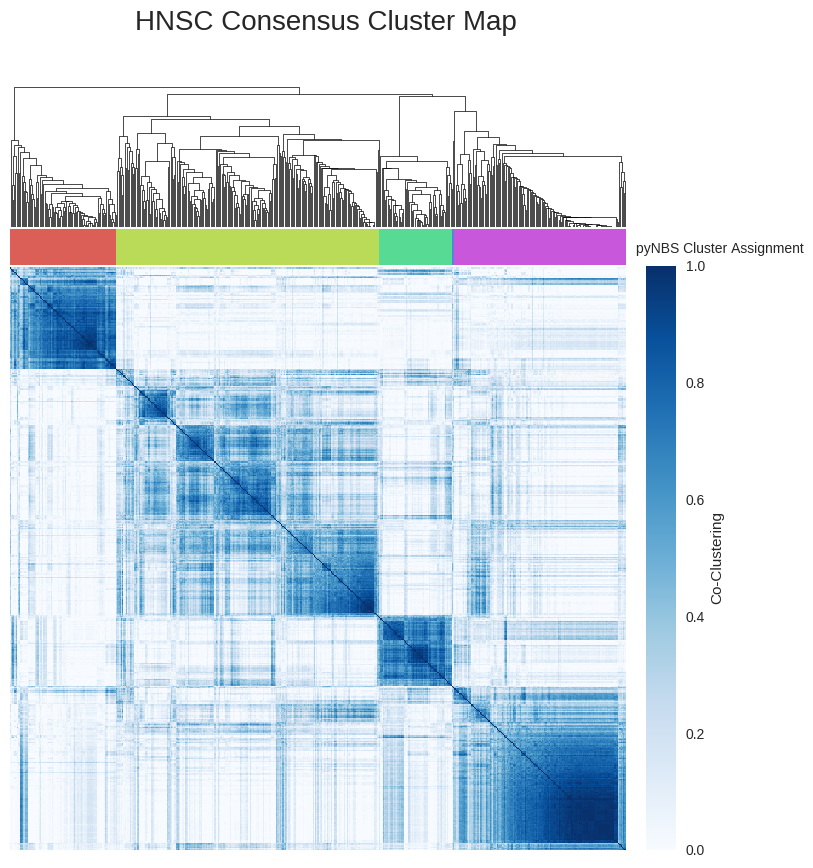

In [71]:
Image(filename = run_pyNBS_params['save_co_cluster_map'], width=600, height=600)

/cellar/users/t1jia/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Multi-Class Log-Rank P: 0.302500088719


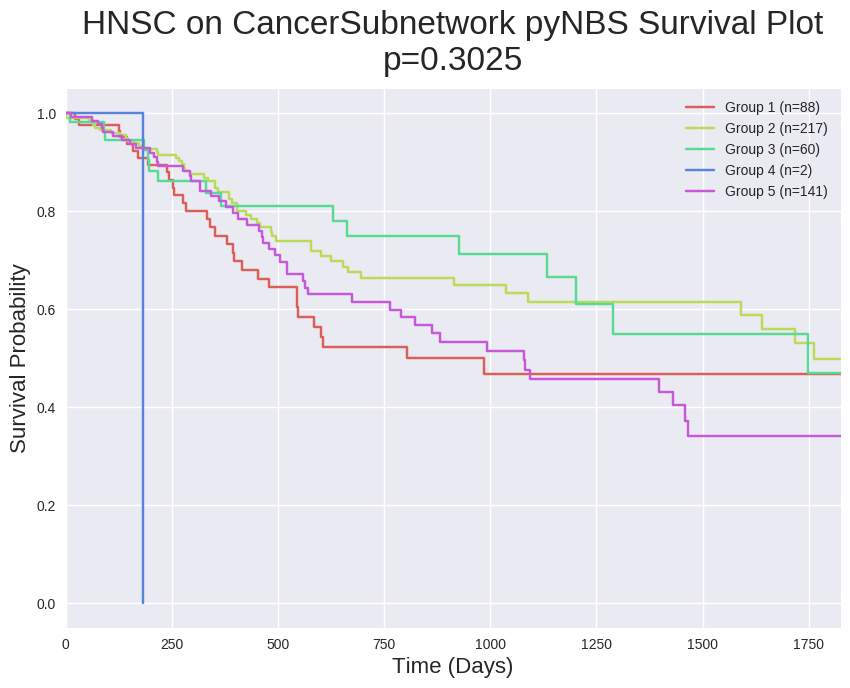

In [72]:
clin_path = '/cellar/users/t1jia/pyNBS/data/Clinical_Files/HNSC.clin.merged.surv.txt'
plot.cluster_KMplot(NBS_cluster_assign,clin_path,title='HNSC on CancerSubnetwork pyNBS Survival Plot', save_path = run_pyNBS_params['save_km_plot'])
Image(filename = run_pyNBS_params['save_km_plot'], width=600, height=600)

## 100x50

In [73]:
run_pyNBS_params = {'verbose' : True,
                    
                    ##### Path for HNSC #####
                    # Data used in this notebook is located in /data folder in the repository.
                    # To run this notebook, please modify the path to indicate your local directory.
                    # If you would like to use your own data file, 
                    # please refer to the "Load data" cell below for formatting details.
                     
                    # Please make sure you modify file path for loading/saving to indicate your local directory                 
                    'sm_data_file' : '/cellar/users/t1jia/pyNBS/data/Mutation_Files/HNSC_sm_data.txt',
                    'network_path' : '/cellar/users/t1jia/pyNBS/data/Network_Files/CancerSubnetwork.txt',
                    
                    'mut_filetype' : 'list',
                    'mut_filedelim' : '\t',
                    'net_filedelim' : '\t',
                    'degree_preserved_shuffle' : False,
                    'node_label_shuffle' : False,
                    
                    'regularize_network' : True,
                    'reg_net_gamma' : 0.01,
                    'k_nearest_neighbors' : 11,
                    'save_knn_glap' : None,
                    'regularization_network_graph_laplacian_file' : None,
                    'niter' : 100, 
                    'calculate_propagation_kernel' : True,
                    
                    'propagation_kernel_file' : None,
                    'save_kernel' : None,
                    'save_H' : None,
                    'consensus_cluster' : True,
                    'assign_clusters' : True,
                    'save_co_cluster_matrix' : '/cellar/users/t1jia/pyNBS/Supplementary_Notebooks/results/net_nmf/HNSC_co_cluster_matrix.csv',
                    'save_cluster_assignments' : '/cellar/users/t1jia/pyNBS/Supplementary_Notebooks/results/net_nmf/HNSC_cluster_assignment.csv',
                    'plot_co_cluster_map' : True,
                    'plot_title' : 'HNSC Consensus Cluster Map',
                    'save_co_cluster_map' : '/cellar/users/t1jia/pyNBS/Supplementary_Notebooks/results/net_nmf/HNSC_co_cluster.png',
                    'save_km_plot' : '/cellar/users/t1jia/pyNBS/Supplementary_Notebooks/results/net_nmf/HNSC_KM_plot.png'
                    }

In [74]:
NBS_options = {'pats_subsample_p' : 0.8, 
               'gene_subsample_p' : 0.8, 
               'min_muts' : 10,
               'prop_data' : True, 
               'prop_alpha' : 0.7, 
               'prop_symmetric_norm' : False, 
               'qnorm_data' : True,
               'netNMF_k' : 4, 
               'netNMF_gamma' : 200, 
               'netNMF_update_gamma' : False, 
               'netNMF_gamma_factor' : 1,
               'netNMF_niter' : 50, 
               'netNMF_eps' : 1e-15, 
               'netNMF_err_tol' : 1e-4, 
               'netNMF_err_delta_tol' : 1e-8}

In [75]:
# Load somatic mutation data
sm_mat = dit.load_binary_mutation_data(run_pyNBS_params['sm_data_file'], filetype=run_pyNBS_params['mut_filetype'], delimiter=run_pyNBS_params['mut_filedelim'], verbose=run_pyNBS_params['verbose'])
# Load network
network = dit.load_network_file(run_pyNBS_params['network_path'], delimiter=run_pyNBS_params['net_filedelim'], degree_shuffle=run_pyNBS_params['degree_preserved_shuffle'], 
                                label_shuffle=run_pyNBS_params['node_label_shuffle'], verbose=run_pyNBS_params['verbose'])


Binary Mutation Matrix Loaded: /cellar/users/t1jia/pyNBS/data/Mutation_Files/HNSC_sm_data.txt
Network File Loaded: /cellar/users/t1jia/pyNBS/data/Network_Files/CancerSubnetwork.txt


In [76]:
# Get knnGlap
if run_pyNBS_params['regularize_network']:
    knnGlap = core.network_inf_KNN_glap(network, gamma=run_pyNBS_params['reg_net_gamma'], kn=run_pyNBS_params['k_nearest_neighbors'], verbose=run_pyNBS_params['verbose'], save_path=run_pyNBS_params['save_knn_glap'])
else:
    # Load propatagion kernel
    if run_pyNBS_params['regularization_network_graph_laplacian_file'].endswith('.hdf'):
        knnGlap = pd.read_hdf(run_pyNBS_params['regularization_network_graph_laplacian_file'])
    else:
        knnGlap = pd.read_csv(run_pyNBS_params['regularization_network_graph_laplacian_file'])
    if run_pyNBS_params['verbose']:
        print 'Pre-calculated regularization network graph laplacian loaded'

Graph influence matrix calculated: 1.85804700851 seconds
Graph laplacian of KNN network from influence matrix calculated: 4.71223211288 seconds


In [77]:
# Get network propagation kernel
if run_pyNBS_params['propagation_kernel_file'] is not None:
    # Load propagation kernel
    if run_pyNBS_params['propagation_kernel_file'].endswith('.hdf'):
        kernel = pd.read_hdf(run_pyNBS_params['propagation_kernel_file'])
    else:
        kernel = pd.read_csv(run_pyNBS_params['propagation_kernel_file'])
    if run_pyNBS_params['verbose']:
        print 'Pre-calculated network kernel loaded'
else:
    if run_pyNBS_params['calculate_propagation_kernel']:
        # Calculate propagation kernel by propagating identity matrix of network
        network_nodes = network.nodes()
        network_I = pd.DataFrame(np.identity(len(network_nodes)), index=network_nodes, columns=network_nodes)
        kernel = prop.network_propagation(network, network_I, NBS_options['prop_alpha'], symmetric_norm=NBS_options['prop_symmetric_norm'], verbose=run_pyNBS_params['verbose'], save_path=run_pyNBS_params['save_kernel'])  
        if run_pyNBS_params['verbose']:
            print 'Network kernel calculated'
    else:
        kernel = None
        if run_pyNBS_params['verbose']:
            print 'No network kernel established'

Performing network propagation with alpha: 0.7
Network Propagation Complete: 3.23777413368 seconds
Network kernel calculated


In [78]:
Hlist = []
for i in range(run_pyNBS_params['niter']):
    netNMF_time = time.time()
    Hlist.append(pyNBS_single.NBS_single(sm_mat, NBS_options, propNet=network, propNet_kernel=kernel, regNet_glap=knnGlap, verbose=False, save_path=run_pyNBS_params['save_H']))
    if run_pyNBS_params['verbose']:
        t = time.time()-netNMF_time
        print 'NBS iteration:', i+1, 'complete:', t, 'seconds'

NBS iteration: 1 complete: 6.01069712639 seconds
NBS iteration: 2 complete: 5.60789299011 seconds
NBS iteration: 3 complete: 6.0006878376 seconds
NBS iteration: 4 complete: 5.59313511848 seconds
NBS iteration: 5 complete: 5.67791986465 seconds
NBS iteration: 6 complete: 5.5812869072 seconds
NBS iteration: 7 complete: 5.63223218918 seconds
NBS iteration: 8 complete: 5.58559417725 seconds
NBS iteration: 9 complete: 6.16593790054 seconds
NBS iteration: 10 complete: 5.60144996643 seconds
NBS iteration: 11 complete: 5.64824414253 seconds
NBS iteration: 12 complete: 5.62513113022 seconds
NBS iteration: 13 complete: 5.6107199192 seconds
NBS iteration: 14 complete: 5.61510300636 seconds
NBS iteration: 15 complete: 5.63756203651 seconds
NBS iteration: 16 complete: 5.60828399658 seconds
NBS iteration: 17 complete: 5.6438100338 seconds
NBS iteration: 18 complete: 5.62178111076 seconds
NBS iteration: 19 complete: 5.61456608772 seconds
NBS iteration: 20 complete: 5.5775539875 seconds
NBS iteration:

In [79]:
if run_pyNBS_params['consensus_cluster']:
    NBS_cc_table, NBS_cc_linkage, NBS_cluster_assign = cc.consensus_hclust_hard(Hlist, NBS_options['netNMF_k'], assign_cluster=run_pyNBS_params['assign_clusters'])
    if run_pyNBS_params['verbose']:
        print 'Consensus Clustering complete'        
    if run_pyNBS_params['save_co_cluster_matrix'] is not None:
        NBS_cc_table.to_csv(run_pyNBS_params['save_co_cluster_matrix'])
        if run_pyNBS_params['verbose']:
            print 'Co-clustering matrix saved'
    if run_pyNBS_params['save_cluster_assignments'] is not None:
        NBS_cluster_assign.to_csv(run_pyNBS_params['save_cluster_assignments'])
        if run_pyNBS_params['verbose']:
            print 'Cluster assignments saved'

Consensus Clustering complete
Co-clustering matrix saved
Cluster assignments saved


In [80]:
# Plot Consensus Cluster Map
if run_pyNBS_params['plot_co_cluster_map']:
    NBS_cluster_assign_cmap = plot.cluster_color_assign(NBS_cluster_assign, name='pyNBS Cluster Assignment')
    plot.plot_cc_map(NBS_cc_table, NBS_cc_linkage, title=run_pyNBS_params['plot_title'], row_color_map=None, 
                     col_color_map=NBS_cluster_assign_cmap, save_path=run_pyNBS_params['save_co_cluster_map'])
    if run_pyNBS_params['verbose']:
        print 'Consensus Clustering map saved'

Consensus Clustering map saved


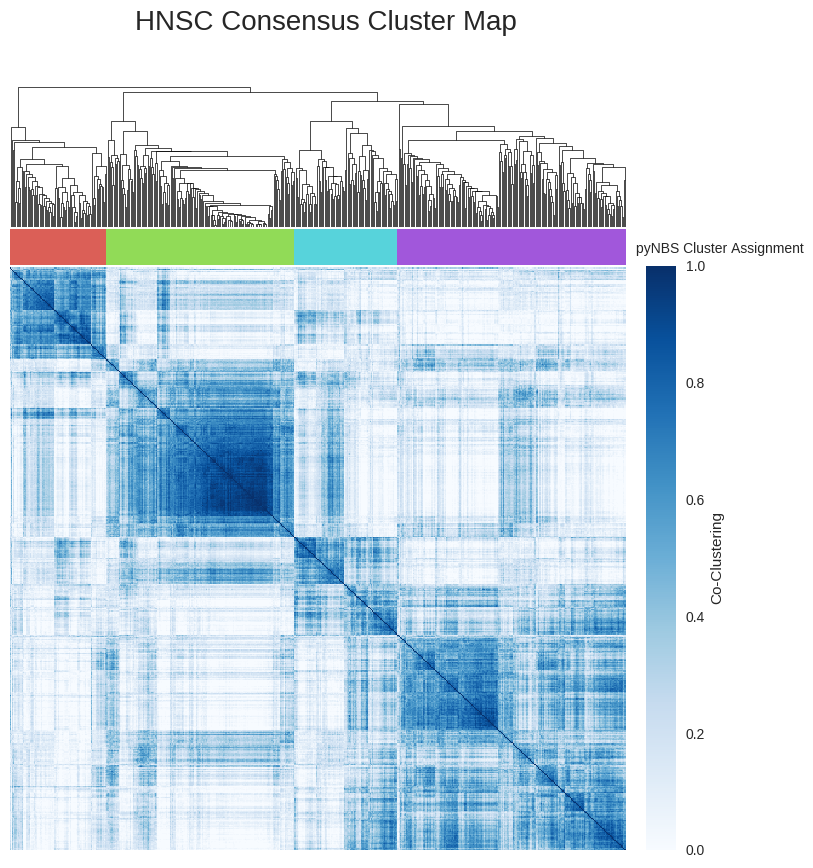

In [81]:
Image(filename = run_pyNBS_params['save_co_cluster_map'], width=600, height=600)

Multi-Class Log-Rank P: 0.163855990248


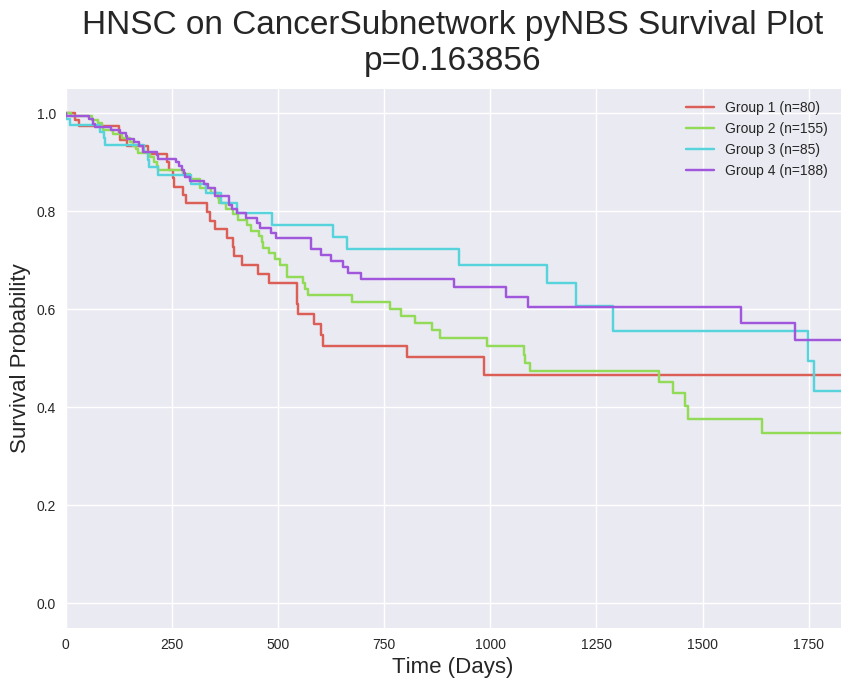

In [82]:
clin_path = '/cellar/users/t1jia/pyNBS/data/Clinical_Files/HNSC.clin.merged.surv.txt'
plot.cluster_KMplot(NBS_cluster_assign,clin_path,title='HNSC on CancerSubnetwork pyNBS Survival Plot', save_path = run_pyNBS_params['save_km_plot'])
Image(filename = run_pyNBS_params['save_km_plot'], width=600, height=600)